# Initialization

In [24]:
import pandas as pd
from sklearn.model_selection import train_test_split
import h5py
import numpy as np
import verstack
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import optuna
from sklearn.preprocessing import StandardScaler, RobustScaler, QuantileTransformer, PowerTransformer
import joblib
from tqdm import tqdm
from sklearn.cluster import DBSCAN, KMeans
import umap


In [25]:
def load_data(name):
    with h5py.File(f'{name}.h5', 'r') as f:
        filename = name.split('/')[1]
        return pd.DataFrame(f[filename][:], dtype=np.float64)

train = load_data('data/train')
test = load_data('data/test')

train

eventNumber  runNumber  actualInteractionsPerCrossing  \
0        87834187.0   300000.0                      26.500000   
1        84862668.0   300000.0                      35.500000   
2        20869557.0   300000.0                      29.490000   
3        42161877.0   300000.0                      37.500000   
4        82761614.0   300000.0                      59.500000   
...             ...        ...                            ...   
162495   87753440.0   300000.0                      59.500000   
162496    7746045.0   300000.0                      11.490000   
162497   85994391.0   300000.0                      44.490002   
162498    9886827.0   300000.0                      20.490000   
162499   32505496.0   300000.0                      33.500000   

        averageInteractionsPerCrossing  correctedActualMu  correctedAverageMu  \
0                            26.500000          26.500000           26.500000   
1                            35.500000          35.500000           35.500000   
2                            29.490000          29.490000           29.490000   
3                            37.500000          37.500000           37.500000   
4                            59.500000          59.500000           59.500000   
...                                ...                ...                 ...   
162495                       59.500000          59.500000           59.500000   
162496                       11.490000          11.490000           11.490000   
162497                       44.490002          44.490002           44.490002   
162498                       20.490000          20.490000           20.490000   
162499                       33.500000          33.500000           33.500000   

        correctedScaledActualMu  correctedScaledAverageMu  NvtxReco  \
0                     26.500000                 26.500000      18.0   
1                     35.500000                 35.500000      23.0   
2                     29.490000                 29.490000      20.0   
3                     37.500000                 37.500000      17.0   
4                     59.500000                 59.500000      33.0   
...                         ...                       ...       ...   
162495                59.500000                 59.500000      34.0   
162496                11.490000                 11.490000      10.0   
162497                44.490002                 44.490002      28.0   
162498                20.490000                 20.490000      14.0   
162499                33.500000                 33.500000      18.0   

        p_nTracks  ...    p_E5x7_Lr1     p_E5x7_Lr2   p_E5x7_Lr3  \
0             3.0  ...  43402.332031   74045.820312   337.980713   
1             4.0  ...  36774.925781   58228.847656   412.321869   
2             3.0  ...  23413.427734   38875.042969  3492.513672   
3             2.0  ...  27372.955078  104002.000000   921.178040   
4             7.0  ...  45745.859375   87924.406250   -75.167221   
...           ...  ...           ...            ...          ...   
162495        2.0  ...  35473.875000   86889.070312   867.511475   
162496        4.0  ...  36722.617188   79933.289062   352.093262   
162497        5.0  ...  26506.359375   52808.492188   287.444580   
162498        1.0  ...  46398.742188  134187.593750  1426.328613   
162499        5.0  ...  34368.222656   73279.906250  8762.319336   

         p_E7x11_Lr0   p_E7x11_Lr1    p_E7x11_Lr2  p_E7x11_Lr3    p_E7x7_Lr0  \
0         273.708801  43091.683594   74447.539062   470.177124    273.708801   
1       10861.282227  37433.324219   61805.964844   460.203613  10861.282227   
2        5705.863281  23728.701172   40497.234375  3333.052734   5705.863281   
3           0.000000  27101.673828  106995.789062  1127.115356      0.000000   
4           0.000000  45947.109375   93710.968750  -188.182098      0.000000   
...              ...           ...            ...          ...           ...   
162495   1120.453857  36

In [26]:
all_variables = ['actualInteractionsPerCrossing', 'averageInteractionsPerCrossing', 'correctedActualMu', 'correctedAverageMu', 'correctedScaledActualMu', 'correctedScaledAverageMu', 'NvtxReco', 'p_nTracks', 'p_pt_track', 'p_eta', 'p_phi', 'p_charge', 'p_qOverP', 'p_z0', 'p_d0', 'p_sigmad0', 'p_d0Sig', 'p_EptRatio', 'p_dPOverP', 'p_z0theta', 'p_etaCluster', 'p_phiCluster', 'p_eCluster', 'p_rawEtaCluster', 'p_rawPhiCluster', 'p_rawECluster', 'p_eClusterLr0', 'p_eClusterLr1', 'p_eClusterLr2', 'p_eClusterLr3', 'p_etaClusterLr1', 'p_etaClusterLr2', 'p_phiClusterLr2', 'p_eAccCluster', 'p_f0Cluster', 'p_etaCalo', 'p_phiCalo', 'p_eTileGap3Cluster', 'p_cellIndexCluster', 'p_phiModCalo', 'p_etaModCalo', 'p_dPhiTH3', 'p_R12', 'p_fTG3', 'p_weta2', 'p_Reta', 'p_Rphi', 'p_Eratio', 'p_f1', 'p_f3', 'p_Rhad', 'p_Rhad1', 'p_deltaEta1', 'p_deltaPhiRescaled2', 'p_TRTPID', 'p_TRTTrackOccupancy', 'p_numberOfInnermostPixelHits', 'p_numberOfPixelHits', 'p_numberOfSCTHits', 'p_numberOfTRTHits', 'p_numberOfTRTXenonHits', 'p_chi2', 'p_ndof', 'p_SharedMuonTrack', 'p_E7x7_Lr2', 'p_E7x7_Lr3', 'p_E_Lr0_HiG', 'p_E_Lr0_LowG', 'p_E_Lr0_MedG', 'p_E_Lr1_HiG', 'p_E_Lr1_LowG', 'p_E_Lr1_MedG', 'p_E_Lr2_HiG', 'p_E_Lr2_LowG', 'p_E_Lr2_MedG', 'p_E_Lr3_HiG', 'p_E_Lr3_LowG', 'p_E_Lr3_MedG', 'p_ambiguityType', 'p_asy1', 'p_author', 'p_barys1', 'p_core57cellsEnergyCorrection', 'p_deltaEta0', 'p_deltaEta2', 'p_deltaEta3', 'p_deltaPhi0', 'p_deltaPhi1', 'p_deltaPhi2', 'p_deltaPhi3', 'p_deltaPhiFromLastMeasurement', 'p_deltaPhiRescaled0', 'p_deltaPhiRescaled1', 'p_deltaPhiRescaled3', 'p_e1152', 'p_e132', 'p_e235', 'p_e255', 'p_e2ts1', 'p_ecore', 'p_emins1', 'p_etconeCorrBitset', 'p_ethad', 'p_ethad1', 'p_f1core', 'p_f3core', 'p_maxEcell_energy', 'p_maxEcell_gain', 'p_maxEcell_time', 'p_maxEcell_x', 'p_maxEcell_y', 'p_maxEcell_z', 'p_nCells_Lr0_HiG', 'p_nCells_Lr0_LowG', 'p_nCells_Lr0_MedG', 'p_nCells_Lr1_HiG', 'p_nCells_Lr1_LowG', 'p_nCells_Lr1_MedG', 'p_nCells_Lr2_HiG', 'p_nCells_Lr2_LowG', 'p_nCells_Lr2_MedG', 'p_nCells_Lr3_HiG', 'p_nCells_Lr3_LowG', 'p_nCells_Lr3_MedG', 'p_pos', 'p_pos7', 'p_poscs1', 'p_poscs2', 'p_ptconeCorrBitset', 'p_ptconecoreTrackPtrCorrection', 'p_r33over37allcalo', 'p_topoetconeCorrBitset', 'p_topoetconecoreConeEnergyCorrection', 'p_topoetconecoreConeSCEnergyCorrection', 'p_weta1', 'p_widths1', 'p_widths2', 'p_wtots1', 'p_e233', 'p_e237', 'p_e277', 'p_e2tsts1', 'p_ehad1', 'p_emaxs1', 'p_fracs1', 'p_DeltaE', 'p_E3x5_Lr0', 'p_E3x5_Lr1', 'p_E3x5_Lr2', 'p_E3x5_Lr3', 'p_E5x7_Lr0', 'p_E5x7_Lr1', 'p_E5x7_Lr2', 'p_E5x7_Lr3', 'p_E7x11_Lr0', 'p_E7x11_Lr1', 'p_E7x11_Lr2', 'p_E7x11_Lr3', 'p_E7x7_Lr0', 'p_E7x7_Lr1' ]

electron_variables = ['actualInteractionsPerCrossing','averageInteractionsPerCrossing','correctedActualMu','correctedAverageMu','correctedScaledActualMu','correctedScaledAverageMu','NvtxReco','p_nTracks','p_pt_track','p_eta','p_phi','p_charge','p_qOverP','p_z0','p_d0','p_sigmad0','p_d0Sig','p_EptRatio','p_dPOverP','p_z0theta','p_etaCluster','p_phiCluster','p_eCluster','p_rawEtaCluster','p_rawPhiCluster','p_rawECluster','p_eClusterLr0','p_eClusterLr1','p_eClusterLr2','p_eClusterLr3','p_etaClusterLr1','p_etaClusterLr2','p_phiClusterLr2','p_eAccCluster','p_f0Cluster','p_etaCalo','p_phiCalo','p_eTileGap3Cluster','p_cellIndexCluster','p_phiModCalo','p_etaModCalo','p_dPhiTH3','p_R12','p_fTG3','p_weta2','p_Reta','p_Rphi','p_Eratio','p_f1','p_f3','p_Rhad','p_Rhad1','p_deltaEta1','p_deltaPhiRescaled2','p_TRTPID','p_TRTTrackOccupancy','p_numberOfInnermostPixelHits','p_numberOfPixelHits','p_numberOfSCTHits','p_numberOfTRTHits','p_numberOfTRTXenonHits','p_chi2','p_ndof','p_SharedMuonTrack','p_E7x7_Lr2','p_E7x7_Lr3','p_E_Lr0_HiG','p_E_Lr0_LowG','p_E_Lr0_MedG','p_E_Lr1_HiG','p_E_Lr1_LowG','p_E_Lr1_MedG','p_E_Lr2_HiG','p_E_Lr2_LowG','p_E_Lr2_MedG','p_E_Lr3_HiG','p_E_Lr3_LowG','p_E_Lr3_MedG','p_ambiguityType','p_asy1','p_author','p_barys1','p_core57cellsEnergyCorrection','p_deltaEta0','p_deltaEta2','p_deltaEta3','p_deltaPhi0','p_deltaPhi1','p_deltaPhi2','p_deltaPhi3','p_deltaPhiFromLastMeasurement','p_deltaPhiRescaled0','p_deltaPhiRescaled1','p_deltaPhiRescaled3','p_e1152','p_e132','p_e235','p_e255','p_e2ts1','p_ecore','p_emins1','p_etconeCorrBitset','p_ethad','p_ethad1','p_f1core','p_f3core','p_maxEcell_energy','p_maxEcell_gain','p_maxEcell_time','p_maxEcell_x','p_maxEcell_y','p_maxEcell_z','p_nCells_Lr0_HiG','p_nCells_Lr0_LowG','p_nCells_Lr0_MedG','p_nCells_Lr1_HiG','p_nCells_Lr1_LowG','p_nCells_Lr1_MedG','p_nCells_Lr2_HiG','p_nCells_Lr2_LowG','p_nCells_Lr2_MedG','p_nCells_Lr3_HiG','p_nCells_Lr3_LowG','p_nCells_Lr3_MedG','p_pos','p_pos7','p_poscs1','p_poscs2','p_ptconeCorrBitset','p_ptconecoreTrackPtrCorrection','p_r33over37allcalo','p_topoetconeCorrBitset','p_topoetconecoreConeEnergyCorrection','p_topoetconecoreConeSCEnergyCorrection','p_weta1','p_widths1','p_widths2','p_wtots1','p_e233','p_e237','p_e277','p_e2tsts1','p_ehad1','p_emaxs1','p_fracs1','p_DeltaE','p_E3x5_Lr0','p_E3x5_Lr1','p_E3x5_Lr2','p_E3x5_Lr3','p_E5x7_Lr0','p_E5x7_Lr1','p_E5x7_Lr2','p_E5x7_Lr3','p_E7x11_Lr0','p_E7x11_Lr1','p_E7x11_Lr2','p_E7x11_Lr3','p_E7x7_Lr0','p_E7x7_Lr1']

# X = train[all_variables]
X = train[electron_variables]
y = train['Truth']

# Classification

## Verstack


 * Initiating LGBMTuner.fit
     . Settings:
     .. Trying 100 trials
     .. Evaluation metric: accuracy 
     .. Study direction: minimize log_loss

     . Trial number: 0 finished
     .. Optimization score (lower-better): log_loss: 0.13636991433049364
     .. Evaluation score (greater-better): accuracy: 0.9477415384615384
 ...........................................................................
     . Trial number: 1 finished
     .. Optimization score (lower-better): log_loss: 0.1385595076777968
     .. Evaluation score (greater-better): accuracy: 0.9461415384615385
 ...........................................................................
     . Trial number: 2 finished
     .. Optimization score (lower-better): log_loss: 0.13757083441342477
     .. Evaluation score (greater-better): accuracy: 0.9458707692307692
 ...........................................................................
     . Trial number: 3 finished
     .. Optimization score (lower-better): log_loss: 0

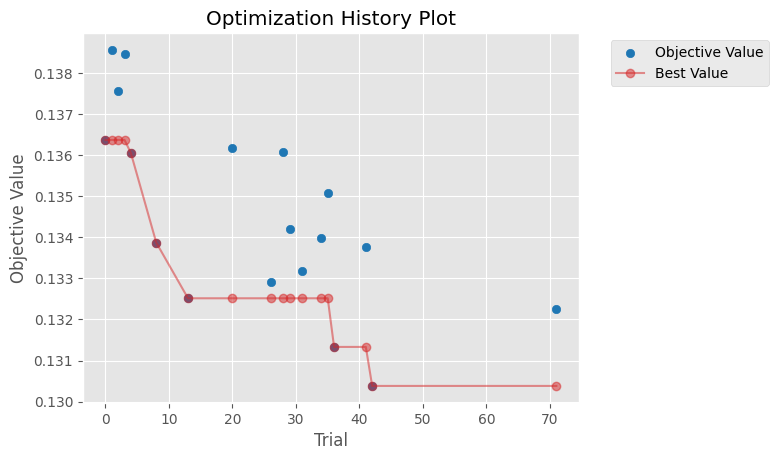

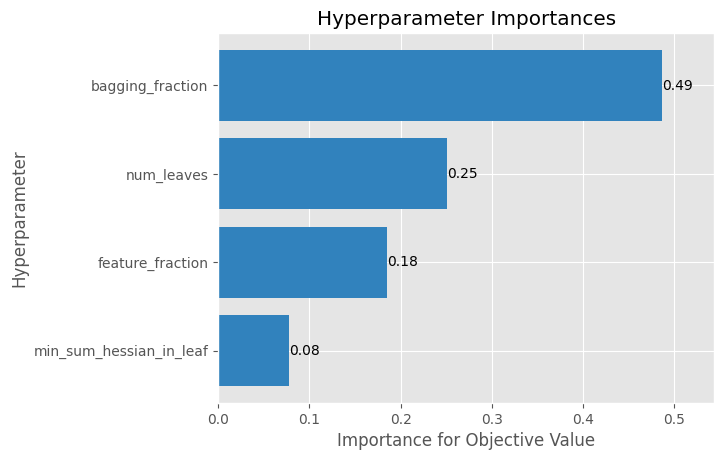

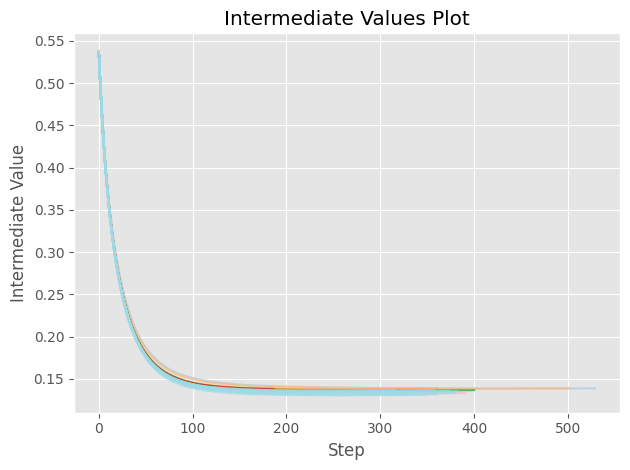

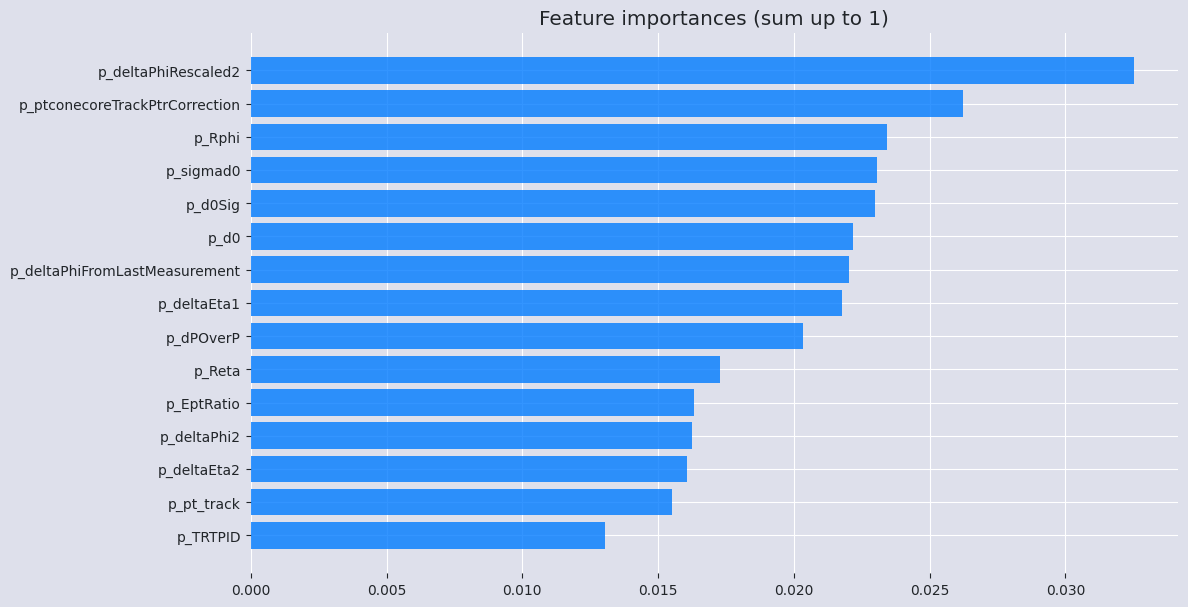


     . Optuna hyperparameters optimization finished
     .. Best trial number:42    |     log_loss:           0.1303818217480927
 ---------------------------------------------------------------------------
     . num_iterations optimization finished
     .. best iteration:  235   |     accuracy:           0.9483076923076923

Time elapsed for fit execution: 9 min 26.382 sec


In [4]:
obj = verstack.LGBMTuner(metric='accuracy', visualization=True)
obj.fit(X, y)

In [5]:
obj.predict_proba(test[all_variables])

array([0.99426246, 0.98359598, 0.98751698, ..., 0.0600176 , 0.00712101,
       0.99604774])

In [6]:
opt_features = list(obj.feature_importances.sort_values(ascending=False)[:15].index)
obj.feature_importances.sort_values(ascending=False)[:15]

p_deltaPhiRescaled2               0.03252
p_ptconecoreTrackPtrCorrection    0.02624
p_Rphi                            0.02343
p_sigmad0                         0.02308
p_d0Sig                           0.02300
p_d0                              0.02217
p_deltaPhiFromLastMeasurement     0.02204
p_deltaEta1                       0.02178
p_dPOverP                         0.02033
p_Reta                            0.01728
p_EptRatio                        0.01633
p_deltaPhi2                       0.01626
p_deltaEta2                       0.01606
p_pt_track                        0.01550
p_TRTPID                          0.01306
dtype: float64

In [7]:
obj.best_params

{'task': 'train',
 'learning_rate': 0.04,
 'num_leaves': 230,
 'feature_fraction': 0.602234088878976,
 'bagging_fraction': 0.7832865980536312,
 'bagging_freq': 1,
 'max_depth': -1,
 'verbosity': -1,
 'lambda_l1': 1,
 'lambda_l2': 0.0,
 'min_split_gain': 0.0,
 'zero_as_missing': False,
 'max_bin': 255,
 'min_data_in_bin': 3,
 'random_state': 42,
 'device_type': 'cpu',
 'num_classes': 1,
 'objective': 'binary',
 'metric': 'binary_logloss',
 'num_threads': 14,
 'min_sum_hessian_in_leaf': 5.707434456880202,
 'num_iterations': 235}


 * Initiating LGBMTuner.fit
     . Settings:
     .. Trying 100 trials
     .. Evaluation metric: accuracy 
     .. Study direction: minimize log_loss

     . Trial number: 0 finished
     .. Optimization score (lower-better): log_loss: 0.1583423669064283
     .. Evaluation score (greater-better): accuracy: 0.9381415384615385
 ...........................................................................
     . Trial number: 1 finished
     .. Optimization score (lower-better): log_loss: 0.15466791807249894
     .. Evaluation score (greater-better): accuracy: 0.9389784615384615
 ...........................................................................
     . Trial number: 2 finished
     .. Optimization score (lower-better): log_loss: 0.1582140668244569
     .. Evaluation score (greater-better): accuracy: 0.9376246153846154
 ...........................................................................
     . Trial number: 3 finished
     .. Optimization score (lower-better): log_loss: 0.

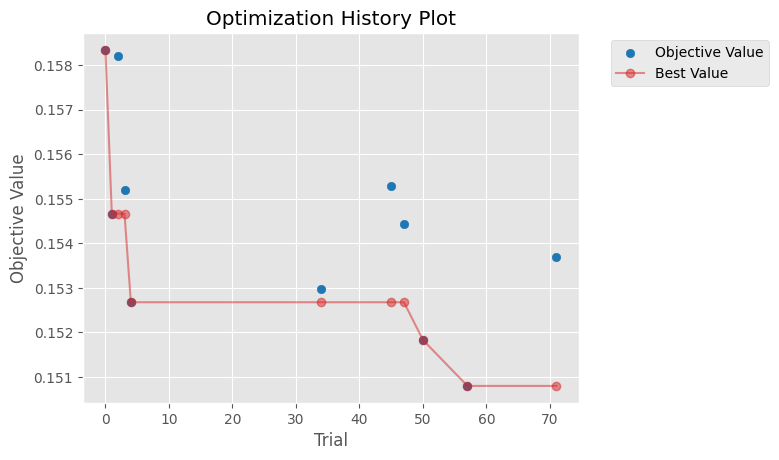

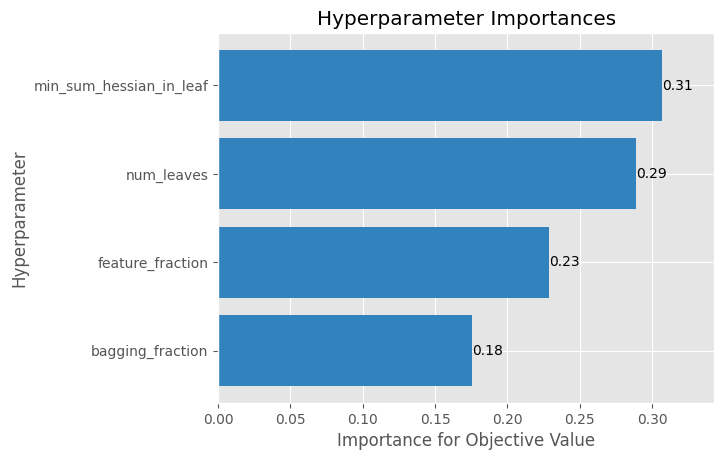

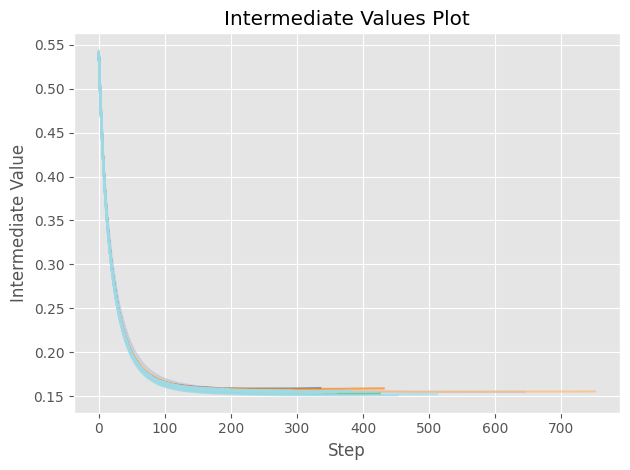

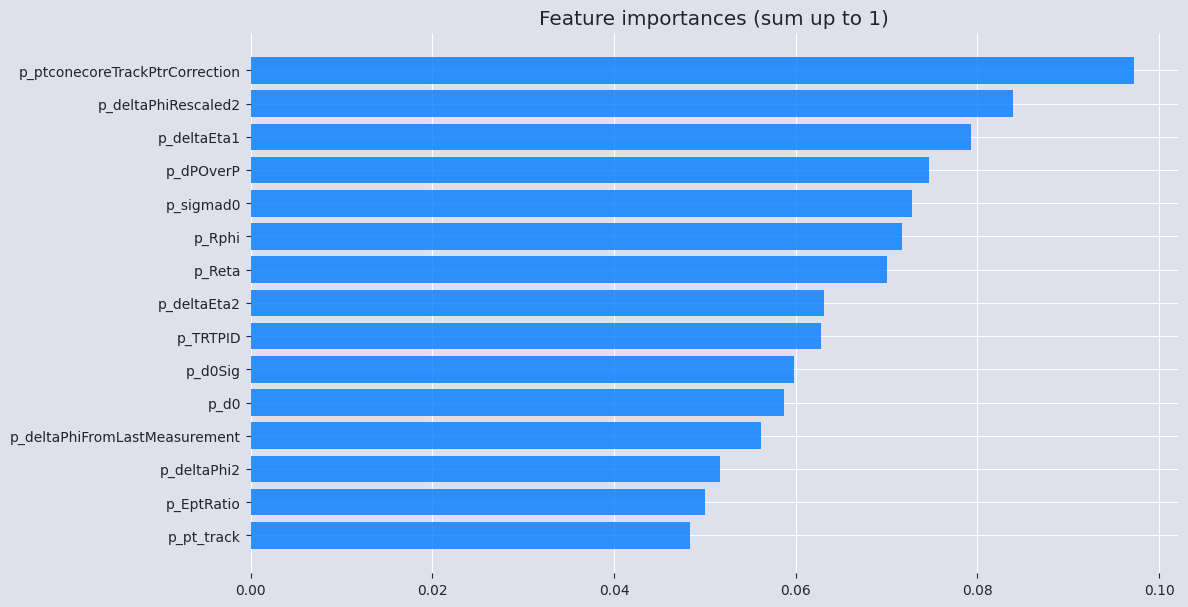


     . Optuna hyperparameters optimization finished
     .. Best trial number:57    |     log_loss:          0.15079925483161377
 ---------------------------------------------------------------------------
     . num_iterations optimization finished
     .. best iteration:  352   |     accuracy:           0.9397661538461538

Time elapsed for fit execution: 6 min 56.253 sec


In [8]:
obj = verstack.LGBMTuner(metric='accuracy')
obj.fit(X[opt_features], y)

#### Saving output

In [9]:
predictions = obj.predict_proba(test[opt_features])

np.savetxt('outputs/Classification_RizNoronha_LightGBM_VariableList.txt', opt_features, fmt='%s')
np.savetxt('outputs/Classification_RizNoronha_LightGBM.txt', np.vstack((test.index, predictions)).T, delimiter=',', fmt=['%i', '%.18e'])

## XGBoost with Optuna

### Finding best features

In [10]:
input_train, input_valid, truth_train, truth_valid = train_test_split(X, y, train_size=0.9, random_state=42)


XGB = XGBClassifier(learning_rate=0.1, n_estimators=300, seed=42)
XGB.fit(input_train, truth_train)

XGB.score(input_valid, truth_valid)

0.9441846153846154

In [11]:
a, b = zip(*sorted(zip(XGB.feature_importances_, X.columns), reverse=True))
xgb_opt_features = list(b[:15])
xgb_opt_features

['p_Rhad',
 'p_ethad',
 'p_ambiguityType',
 'p_numberOfInnermostPixelHits',
 'p_Rhad1',
 'p_sigmad0',
 'p_Reta',
 'p_Rphi',
 'p_ethad1',
 'p_nTracks',
 'p_deltaEta1',
 'p_ehad1',
 'p_deltaPhiRescaled2',
 'p_numberOfPixelHits',
 'p_e2tsts1']

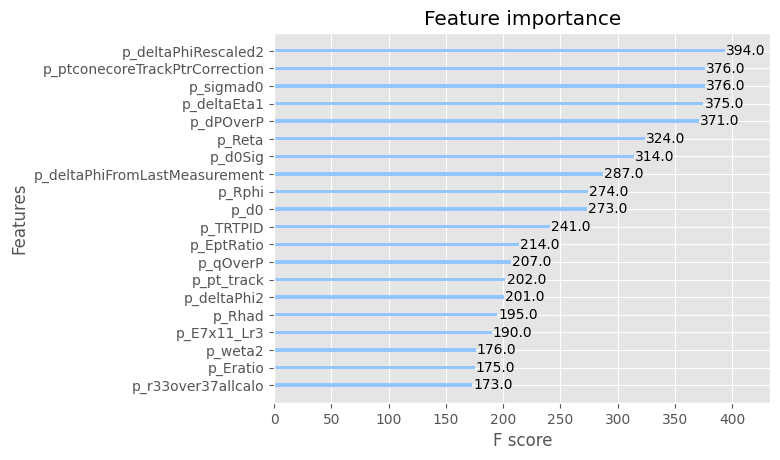

In [12]:
import xgboost

xgboost.plot_importance(XGB, max_num_features=20);

In [13]:
input_train, input_valid, truth_train, truth_valid = train_test_split(X[xgb_opt_features], y, train_size=0.9, random_state=42)


XGB = XGBClassifier(learning_rate=0.1, n_estimators=300, seed=42, eval_metric='logloss')
XGB.fit(input_train, truth_train)

tf.losses.binary_crossentropy(truth_valid, XGB.predict_proba(input_valid)[:,1]).numpy()

0.16864051

### Hyperparameter optimization

In [14]:
import optuna
from xgboost import XGBClassifier

def objective(trial):
    """Define the objective function"""

    params = {
        'max_depth': trial.suggest_int('max_depth', 1, 9),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'subsample': trial.suggest_loguniform('subsample', 0.01, 1.0),
        'colsample_bytree': trial.suggest_loguniform('colsample_bytree', 0.01, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
        'eval_metric': 'mlogloss',
        'use_label_encoder': False
    }

    # Fit the model
    optuna_model = XGBClassifier(**params)
    optuna_model.fit(input_train, truth_train)

    # Make and evaluate predictions
    predictions = optuna_model.predict_proba(input_valid)[:,1]

    return tf.losses.binary_crossentropy(truth_valid, predictions).numpy()


In [15]:
# study = optuna.create_study(direction='minimize')
study = joblib.load('data/optuna_xgb_classification.study')

# study.optimize(objective, n_trials=100)
# joblib.dump(study, 'data/optuna_xgb_classification.study')



print('Number of finished trials: {}'.format(len(study.trials)))
print('Best trial:')
trial = study.best_trial

print('  Value: {}'.format(trial.value))
print('  Params: ')

for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

Number of finished trials: 100
Best trial:
  Value: 0.16660818457603455
  Params: 
    max_depth: 9
    learning_rate: 0.0237538176361407
    n_estimators: 498
    min_child_weight: 4
    gamma: 2.2703433591971862e-06
    subsample: 0.5412550333578701
    colsample_bytree: 0.5627792454863988
    reg_alpha: 0.006667955868867927
    reg_lambda: 1.1900106480488672e-05


In [16]:
params = trial.params
n_estimators = params.pop('n_estimators')

data_dmatrix = xgboost.DMatrix(data=X[xgb_opt_features], label=y)

xgb_cv = xgboost.cv(dtrain=data_dmatrix, nfold=5, params=params, num_boost_round=n_estimators, as_pandas=True, metrics='logloss', seed=42)

xgb_cv

train-logloss-mean  train-logloss-std  test-logloss-mean  \
0              0.674373           0.000021           0.674538   
1              0.656835           0.000089           0.657172   
2              0.639957           0.000139           0.640471   
3              0.623896           0.000087           0.624582   
4              0.608464           0.000203           0.609330   
..                  ...                ...                ...   
493            0.119038           0.000635           0.177894   
494            0.118934           0.000637           0.177906   
495            0.118841           0.000726           0.177925   
496            0.118767           0.000772           0.178085   
497            0.118726           0.000753           0.178080   

     test-logloss-std  
0            0.000053  
1            0.000172  
2            0.000231  
3            0.000166  
4            0.000378  
..                ...  
493          0.005062  
494          0.005058  
495          0.004677  
496          0.004965  
497          0.004966  

[498 rows x 4 columns]

In [17]:
xgb_cv[190:200]

train-logloss-mean  train-logloss-std  test-logloss-mean  \
190            0.139918           0.000467           0.166464   
191            0.139749           0.000483           0.166581   
192            0.139593           0.000488           0.166501   
193            0.139426           0.000499           0.166456   
194            0.139270           0.000484           0.166406   
195            0.139121           0.000480           0.166159   
196            0.138991           0.000436           0.166104   
197            0.138830           0.000444           0.166238   
198            0.138692           0.000422           0.166384   
199            0.138619           0.000421           0.166682   

     test-logloss-std  
190          0.003126  
191          0.002865  
192          0.002876  
193          0.002883  
194          0.002878  
195          0.002633  
196          0.002657  
197          0.002882  
198          0.003071  
199          0.002782

In [18]:
input_train, input_valid, truth_train, truth_valid = train_test_split(X[xgb_opt_features], y, train_size=0.8, random_state=42)
# params['n_estimators'] = n_estimators
params['n_estimators'] = 195


XGB = XGBClassifier(**params)
XGB.fit(input_train, truth_train)

predictions = XGB.predict_proba(input_valid)[:,1]

tf.losses.binary_crossentropy(truth_valid, predictions).numpy()

0.16802397

#### Saving output

In [19]:
predictions = XGB.predict_proba(test[xgb_opt_features])[:,1]

np.savetxt('outputs/Classification_RizNoronha_XGBoost_VariableList.txt', xgb_opt_features, fmt='%s')
np.savetxt('outputs/Classification_RizNoronha_XGBoost.txt', np.vstack((test.index, predictions)).T, delimiter=',', fmt=['%i', '%.18e'])

## Neural Network

In [20]:
from scipy import stats

X[(np.abs(stats.zscore(X)) < 100000).all(axis=1)]

Empty DataFrame
Columns: [actualInteractionsPerCrossing, averageInteractionsPerCrossing, correctedActualMu, correctedAverageMu, correctedScaledActualMu, correctedScaledAverageMu, NvtxReco, p_nTracks, p_pt_track, p_eta, p_phi, p_charge, p_qOverP, p_z0, p_d0, p_sigmad0, p_d0Sig, p_EptRatio, p_dPOverP, p_z0theta, p_etaCluster, p_phiCluster, p_eCluster, p_rawEtaCluster, p_rawPhiCluster, p_rawECluster, p_eClusterLr0, p_eClusterLr1, p_eClusterLr2, p_eClusterLr3, p_etaClusterLr1, p_etaClusterLr2, p_phiClusterLr2, p_eAccCluster, p_f0Cluster, p_etaCalo, p_phiCalo, p_eTileGap3Cluster, p_cellIndexCluster, p_phiModCalo, p_etaModCalo, p_dPhiTH3, p_R12, p_fTG3, p_weta2, p_Reta, p_Rphi, p_Eratio, p_f1, p_f3, p_Rhad, p_Rhad1, p_deltaEta1, p_deltaPhiRescaled2, p_TRTPID, p_TRTTrackOccupancy, p_numberOfInnermostPixelHits, p_numberOfPixelHits, p_numberOfSCTHits, p_numberOfTRTHits, p_numberOfTRTXenonHits, p_chi2, p_ndof, p_SharedMuonTrack, p_E7x7_Lr2, p_E7x7_Lr3, p_E_Lr0_HiG, p_E_Lr0_LowG, p_E_Lr0_MedG, p_E_Lr1_HiG, p_E_Lr1_LowG, p_E_Lr1_MedG, p_E_Lr2_HiG, p_E_Lr2_LowG, p_E_Lr2_MedG, p_E_Lr3_HiG, p_E_Lr3_LowG, p_E_Lr3_MedG, p_ambiguityType, p_asy1, p_author, p_barys1, p_core57cellsEnergyCorrection, p_deltaEta0, p_deltaEta2, p_deltaEta3, p_deltaPhi0, p_deltaPhi1, p_deltaPhi2, p_deltaPhi3, p_deltaPhiFromLastMeasurement, p_deltaPhiRescaled0, p_deltaPhiRescaled1, p_deltaPhiRescaled3, p_e1152, p_e132, p_e235, p_e255, p_e2ts1, p_ecore, ...]
Index: []

[0 rows x 160 columns]

In [21]:
X[opt_features].describe()

p_deltaPhiRescaled2  p_ptconecoreTrackPtrCorrection         p_Rphi  \
count        162500.000000                    1.625000e+05  162500.000000   
mean             -0.053935                    3.016883e+04       0.906449   
std               8.518389                    8.611457e+05       0.074041   
min           -1297.900879                    0.000000e+00       0.000000   
25%              -0.001807                    1.479927e+04       0.894428   
50%               0.000585                    2.560676e+04       0.933293   
75%               0.003874                    3.466562e+04       0.949513   
max               0.497833                    3.448992e+08       4.815775   

           p_sigmad0        p_d0Sig           p_d0  \
count  162500.000000  162500.000000  162500.000000   
mean        0.043753      -0.070421      -0.006978   
std         0.254252       8.006779       1.018138   
min         0.007177    -818.559814     -37.931423   
25%         0.015823      -0.804442      -0.017091   
50%         0.020408       0.005717       0.000111   
75%         0.032620       0.817545       0.017175   
max        90.347443     592.257996      40.379303   

       p_deltaPhiFromLastMeasurement    p_deltaEta1      p_dPOverP  \
count                  162500.000000  162500.000000  162500.000000   
mean                      -14.555532      -0.013556       0.401223   
std                       119.636867       5.460531       0.410308   
min                      -999.000000   -2201.196533      -4.000000   
25%                        -0.015548      -0.001106       0.178630   
50%                        -0.004097      -0.000047       0.356191   
75%                        -0.000501       0.001013       0.667787   
max                         2.698916       0.210166       0.999977   

              p_Reta     p_EptRatio    p_deltaPhi2    p_deltaEta2  \
count  162500.000000  162500.000000  162500.000000  162500.000000   
mean        0.909008       3.103862      -0.011305       0.000009   
std         0.069805       6.421212       0.038727       0.006926   
min        -0.006000       0.000207      -0.699607      -0.117263   
25%         0.911298       1.003030      -0.007918      -0.000844   
50%         0.930191       1.315141      -0.001657      -0.000014   
75%         0.943325       2.393792       0.000547       0.000820   
max         1.342384     122.654770       0.143387       0.091991   

         p_pt_track       p_TRTPID  
count  1.625000e+05  162500.000000  
mean   3.767370e+04       0.170403  
std    6.398419e+05       0.342043  
min    3.916667e+02      -0.776530  
25%    1.579378e+04      -0.000000  
50%    2.871401e+04      -0.000000  
75%    3.907144e+04       0.312053  
max    2.347504e+08       2.295614

In [22]:
X['p_deltaPhiRescaled2'].describe()

count    162500.000000
mean         -0.053935
std           8.518389
min       -1297.900879
25%          -0.001807
50%           0.000585
75%           0.003874
max           0.497833
Name: p_deltaPhiRescaled2, dtype: float64

In [23]:
X['p_deltaPhiRescaled2'].sort_values().head(25)

33679    -1297.900879
34869    -1297.900879
20646    -1297.900879
155143   -1297.900879
116653   -1297.900879
148007   -1297.900879
76369    -1297.900879
123736      -0.215086
6803        -0.213220
157036      -0.207897
67488       -0.206812
49141       -0.196149
137803      -0.184515
17696       -0.180961
114612      -0.178811
106078      -0.175046
37144       -0.170164
127113      -0.168639
140169      -0.168555
86985       -0.168202
90139       -0.162976
55336       -0.158422
157644      -0.156339
20296       -0.156261
8061        -0.155460
Name: p_deltaPhiRescaled2, dtype: float64

In [24]:
from sklearn.preprocessing import StandardScaler

scalar = StandardScaler()

X_transform = scalar.fit_transform(X[opt_features], y)

X_transform = pd.DataFrame(X_transform, columns=opt_features)
X_transform

p_deltaPhiRescaled2  p_ptconecoreTrackPtrCorrection    p_Rphi  \
0                  0.006426                        0.009479  0.714613   
1                  0.006213                       -0.035033 -0.890548   
2                  0.007730                       -0.009795  0.355243   
3                  0.006419                        0.002417  0.604344   
4                  0.006834                       -0.008708 -0.514635   
...                     ...                             ...       ...   
162495             0.006308                       -0.006177  0.646735   
162496             0.007724                       -0.023412 -0.367933   
162497             0.005693                        0.001605  0.987240   
162498            -0.000383                       -0.035033  0.610350   
162499             0.007704                        0.039436 -1.447495   

        p_sigmad0   p_d0Sig      p_d0  p_deltaPhiFromLastMeasurement  \
0       -0.116413 -0.134149 -0.009058                       0.121671   
1       -0.038829 -0.030214 -0.003540                       0.121227   
2       -0.100487  0.058110  0.013914                       0.121680   
3       -0.115726  0.250881  0.034135                       0.121668   
4       -0.047909  0.113295  0.032800                       0.121574   
...           ...       ...       ...                            ...   
162495  -0.099811  0.005695  0.006406                       0.121641   
162496   0.105709 -0.432893 -0.238479                       0.121421   
162497  -0.118545  0.082503  0.014745                       0.121626   
162498   0.134723  0.410370  0.253203                       0.119892   
162499  -0.106901  0.014015  0.007534                       0.121696   

        p_deltaEta1  p_dPOverP    p_Reta  p_EptRatio  p_deltaPhi2  \
0          0.002355   0.347367  0.572616   -0.335423     0.314450   
1          0.002845   1.249101  0.334776   -0.301229     0.239895   
2         -0.000756  -0.858713  0.151158   -0.227031     0.350068   
3          0.002758   0.932135  0.593225   -0.359674     0.332537   
4          0.002081  -0.561015  0.356821    0.015854     0.029598   
...             ...        ...       ...         ...          ...   
162495     0.002505   0.221901  0.264425   -0.326596     0.286182   
162496     0.002508  -0.452487  0.467257    0.602914    -0.480647   
162497     0.002329   0.361059  0.613371   -0.335308     0.192597   
162498    -0.011399   1.363972  0.101479    1.150174    -1.588511   
162499    -0.003906  -0.473688 -0.283730   -0.240400     0.403520   

        p_deltaEta2  p_pt_track  p_TRTPID  
0         -0.079966    0.006780 -0.714799  
1          0.240462    0.003203  0.195788  
2         -1.108373   -0.029578 -1.286565  
3          0.027773    0.011411 -0.398956  
4          0.008955   -0.041757 -0.498194  
...             ...         ...       ...  
162495     0.113479    0.003521  1.510833  
162496    -0.114682   -0.051062  0.238440  
162497     0.130713    0.000093  0.881158  
162498    -5.074924   -0.053241 -0.498194  
162499    -2.665226   -0.027467 -0.825214  

[162500 rows x 15 columns]

### Trying with robust scaler

In [138]:
opt_features = ['p_deltaPhiRescaled2'           ,                'p_ptconecoreTrackPtrCorrection',                'p_deltaEta1',                'p_d0Sig'    ,                'p_d0'       ,                'p_sigmad0'  , 'p_Rphi'     ,                'p_dPOverP'  ,                'p_deltaPhiFromLastMeasurement' , 'p_Reta'     ,                'p_deltaPhi2',                'p_EptRatio' ,                'p_TRTPID'   ,                'p_deltaEta2',                'p_E7x11_Lr3',]

In [25]:
from sklearn.preprocessing import RobustScaler

scalar = RobustScaler(quantile_range=[10, 90])

X_transform = scalar.fit_transform(X, y)

X_transform = pd.DataFrame(X_transform, columns=X.columns)
X_transform.describe()

actualInteractionsPerCrossing  averageInteractionsPerCrossing  \
count                  162500.000000                   162500.000000   
mean                        0.051215                        0.051215   
std                         0.374037                        0.374037   
min                        -0.771429                       -0.771429   
25%                        -0.228571                       -0.228571   
50%                         0.000000                        0.000000   
75%                         0.285714                        0.285714   
max                         1.285714                        1.285714   

       correctedActualMu  correctedAverageMu  correctedScaledActualMu  \
count      162500.000000       162500.000000            162500.000000   
mean            0.051215            0.051215                 0.051215   
std             0.374037            0.374037                 0.374037   
min            -0.771429           -0.771429                -0.771429   
25%            -0.228571           -0.228571                -0.228571   
50%             0.000000            0.000000                 0.000000   
75%             0.285714            0.285714                 0.285714   
max             1.285714            1.285714                 1.285714   

       correctedScaledAverageMu       NvtxReco      p_nTracks     p_pt_track  \
count             162500.000000  162500.000000  162500.000000  162500.000000   
mean                   0.051215       0.049154       0.040617       0.213350   
std                    0.374037       0.375676       0.385396      15.236089   
min                   -0.771429      -1.058824      -0.400000      -0.674419   
25%                   -0.228571      -0.235294      -0.200000      -0.307660   
50%                    0.000000       0.000000       0.000000       0.000000   
75%                    0.285714       0.294118       0.200000       0.246634   
max                    1.285714       2.000000       3.000000    5589.254860   

               p_eta  ...     p_E5x7_Lr0     p_E5x7_Lr1     p_E5x7_Lr2  \
count  162500.000000  ...  162500.000000  162500.000000  162500.000000   
mean        0.337249  ...       0.273562       0.052838       0.029434   
std         0.441079  ...       0.446771       0.404668       0.384988   
min        -0.210453  ...      -0.117883      -1.105615      -0.815868   
25%        -0.095769  ...       0.000000      -0.221951      -0.258327   
50%         0.000000  ...       0.000000       0.000000       0.000000   
75%         0.772442  ...       0.507138       0.281821       0.267835   
max         0.886467  ...       6.432760       9.816392       9.178283   

          p_E5x7_Lr3    p_E7x11_Lr0    p_E7x11_Lr1    p_E7x11_Lr2  \
count  162500.000000  162500.000000  162500.000000  162500.000000   
mean        0.343646       0.274471       0.056077       0.032016   
std         1.372793       0.447478       0.406884       0.388360   
min        -1.040523      -0.205151      -1.109523      -0.813243   
25%        -0.093131       0.000000      -0.221065      -0.256195   
50%         0.000000       0.000000       0.000000       0.000000   
75%         0.174307       0.507923       0.284289       0.268171   
max        50.530107       6.804657       9.778825      11.134975   

         p_E7x11_Lr3     p_E7x7_Lr0     p_E7x7_Lr1  
count  162500.000000  162500.000000  162500.000000  
mean        0.311065       0.274484       0.055824  
std         1.174616       0.447672       0.406800  
min        -0.768002      -0.205314      -1.109111  
25%        -0.092703       0.000000      -0.220928  
50%         0.000000       0.000000       0.000000  
75%         0.179054       0.507518       0.283829  
max        40.487494       6.810072       9.785795  

[8 rows x 160 columns]

In [144]:
from sklearn.model_selection import train_test_split

input_train, input_valid, truth_train, truth_valid = train_test_split(X_transform, y, train_size=0.8)

In [147]:
# model = Sequential([
#     Dense(len(input_train.columns),activation='relu',name='input_layer'),
#     Dense(50,activation='relu',name='hidden_layer1'),
#     Dense(20,activation='relu',name='hidden_layer2'),
#     Dense(10,activation='relu',name='hidden_layer3'),
#     Dense(1, activation='sigmoid', name='output')])
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
#               loss=tf.keras.losses.BinaryCrossentropy(),
#               metrics=[tf.keras.metrics.Accuracy()])

# print('--------- TRAINING ---------')
# history = model.fit(x = np.array(input_train), 
#                     y = np.array(truth_train), 
#                     validation_data=(np.array(input_valid), np.array(truth_valid)), 
#                     epochs = 200,
#                     batch_size=1024,
#                     callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=30, restore_best_weights=True)])  

model = Sequential([
    Dense(76,activation='relu',name='hidden_layer1'),
    Dense(64,activation='relu',name='hidden_layer2'),
    Dense(1, activation='sigmoid', name='output')])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.002618239735357655),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.Accuracy()])

print('--------- TRAINING ---------')
history = model.fit(x = np.array(input_train), 
                    y = np.array(truth_train), 
                    validation_data=(np.array(input_valid), np.array(truth_valid)), 
                    epochs = 200,
                    batch_size=1024,
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=30, restore_best_weights=True)])  

--------- TRAINING ---------
Epoch 1/200
127/127 [==============================] - 1s 5ms/step - loss: 2.0404 - accuracy: 0.0331 - val_loss: 0.4873 - val_accuracy: 0.0150
Epoch 2/200
127/127 [==============================] - 0s 4ms/step - loss: 1.2455 - accuracy: 0.0272 - val_loss: 1.0172 - val_accuracy: 0.0131
Epoch 3/200
127/127 [==============================] - 0s 4ms/step - loss: 0.8607 - accuracy: 0.0213 - val_loss: 0.7424 - val_accuracy: 0.0600
Epoch 4/200
127/127 [==============================] - 0s 4ms/step - loss: 0.7302 - accuracy: 0.0290 - val_loss: 0.4775 - val_accuracy: 0.0133
Epoch 5/200
127/127 [==============================] - 0s 4ms/step - loss: 0.5575 - accuracy: 0.0194 - val_loss: 0.4473 - val_accuracy: 0.0150
Epoch 6/200
127/127 [==============================] - 0s 4ms/step - loss: 0.4884 - accuracy: 0.0199 - val_loss: 0.2502 - val_accuracy: 0.0032
Epoch 7/200
127/127 [==============================] - 0s 4ms/step - loss: 0.3765 - accuracy: 0.0110 - val_loss: 

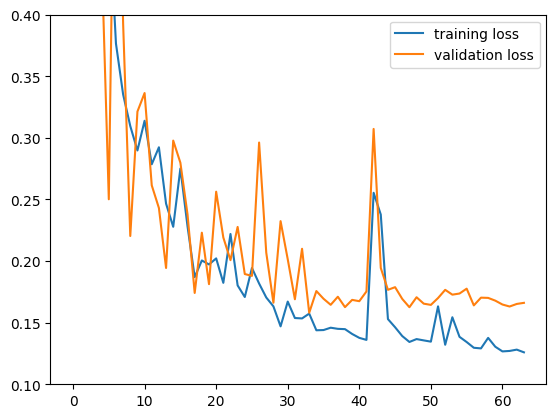

In [148]:
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.ylim(0.1, 0.4)
plt.legend();

### Permutation Importance

In [149]:
init_loss = tf.keras.losses.binary_crossentropy(truth_valid.values, model.predict(input_valid)[:, 0]).numpy()
repeat = 1
importances = np.zeros(len(input_valid.columns))

for i in range(repeat):
    importance_list = []
    for col in tqdm(input_valid.columns):
        shuffled_df = input_valid.copy()
        shuffled_df[col] = shuffled_df[col].sample(frac=1).values
        predictions = model.predict(shuffled_df, verbose=0)[:,0]
        new_loss = tf.keras.losses.binary_crossentropy(truth_valid.values, predictions).numpy()
        importance_list.append((new_loss - init_loss) / init_loss)
    importances += np.array(importance_list)

importances /= repeat

importance_df = pd.DataFrame({"imp":importances, "col":input_valid.columns})
# importance_df['imp'] = importance_df['imp'].apply(abs)
# importance_df.sort_values('imp')
importance_df = importance_df.reindex(importance_df['imp'].abs().sort_values(ascending=False).index)
importance_df

1016/1016 [==============================] - 1s 621us/step


100%|██████████| 160/160 [02:15<00:00,  1.18it/s]


imp                     col
135  8.408646               p_widths1
79   5.872667                  p_asy1
134  5.813272                 p_weta1
124  4.541508                   p_pos
126  1.571149                p_poscs1
..        ...                     ...
136  0.000000               p_widths2
76   0.000000            p_E_Lr3_LowG
128  0.000000      p_ptconeCorrBitset
131  0.000000  p_topoetconeCorrBitset
101  0.000000      p_etconeCorrBitset

[160 rows x 2 columns]

In [100]:
tf_opt_features = importance_df['col'][:15].values
tf_opt_features

array(['p_weta1', 'p_widths1', 'p_asy1', 'p_pos', 'p_poscs1', 'p_pos7',
       'p_wtots1', 'p_ethad', 'p_E7x11_Lr3', 'p_deltaEta1', 'p_sigmad0',
       'p_deltaPhi2', 'p_barys1', 'p_d0Sig', 'p_E_Lr3_MedG'], dtype=object)

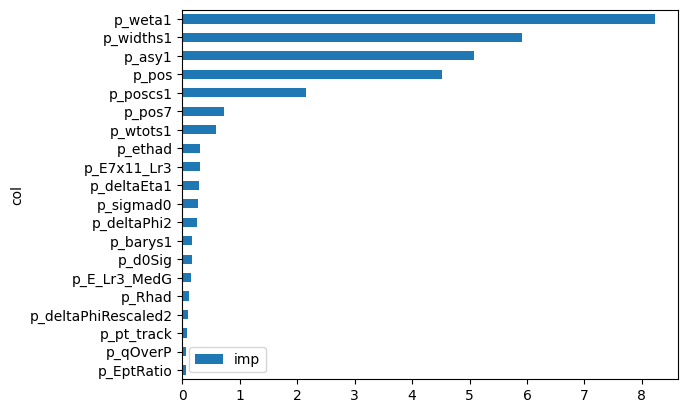

In [101]:
ax = importance_df[:20].plot.barh('col', 'imp')
ax.invert_yaxis()

### SHAP values

In [104]:
import shap

shap.initjs()

shap_rows = shap.sample(input_valid, 512)

# explainer = shap.KernelExplainer(model, input_valid)
# shap_values = explainer.shap_values(input_valid)
explainer = shap.DeepExplainer(model, np.array(input_valid))
shap_values = explainer.shap_values(np.array(shap_rows))

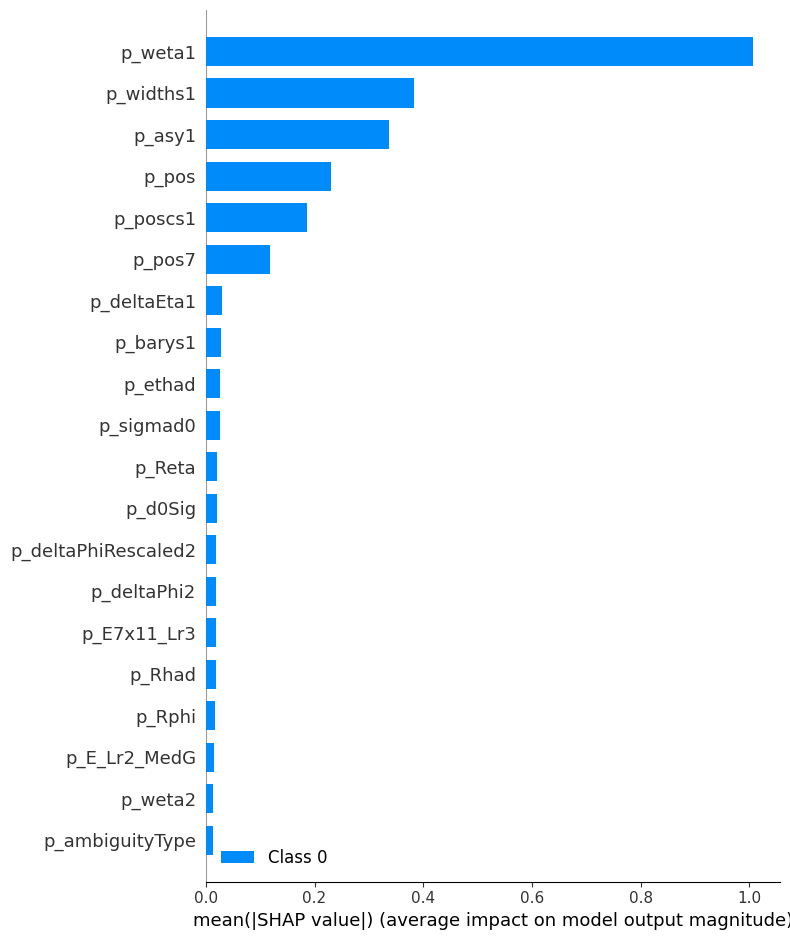

In [105]:
shap.summary_plot(shap_values, input_valid, plot_type="bar")

In [124]:
a,b = zip(*sorted(zip(np.mean(shap_values, axis=1)[0], input_valid.columns)))
tf_opt_features = list(b[:15])
tf_opt_features

['p_weta1',
 'p_pt_track',
 'p_pos7',
 'p_sigmad0',
 'p_nCells_Lr1_HiG',
 'p_phi',
 'p_dPOverP',
 'p_numberOfSCTHits',
 'p_etaCluster',
 'p_maxEcell_gain',
 'p_etaClusterLr2',
 'p_E7x7_Lr1',
 'p_etaCalo',
 'p_etaClusterLr1',
 'p_maxEcell_z']

### Trying optuna

In [56]:
from sklearn.preprocessing import RobustScaler

scalar = RobustScaler(quantile_range=[10, 90])

X_transform = scalar.fit_transform(X[tf_opt_features], y)

X_transform = pd.DataFrame(X_transform, columns=tf_opt_features)

input_train, input_valid, truth_train, truth_valid = train_test_split(X_transform, y, train_size=0.8)

input_train

NameError: name 'tf_opt_features' is not defined

In [129]:
def objective(trial):
  n_layers = trial.suggest_int("n_layers", 1, 4)
  model = tf.keras.Sequential()
  # model.add(Dense(len(input_train.columns),activation='relu',name='input_layer'))  # I think keras automatically does this?
  for i in range(n_layers):
    num_hidden = trial.suggest_int("n_units_l{}".format(i), 1, 128, log=True)
    model.add(Dense(num_hidden, activation="relu"))
  model.add(Dense(1, activation='sigmoid', name='output'))

  lr = trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True)
  model.compile(tf.optimizers.Adam(learning_rate=lr),
                tf.losses.BinaryCrossentropy())
  history = model.fit(x = np.array(input_train), 
                      y = np.array(truth_train), 
                      validation_data=(np.array(input_valid), np.array(truth_valid)), 
                      epochs = 200,
                      batch_size=1024,
                      callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=30, restore_best_weights=True)],
                      verbose = 0)  
  return np.min(history.history['val_loss'])

In [31]:
# study = optuna.create_study(direction='minimize')
study = joblib.load('data/optuna_tf_classification.study')

# study.optimize(objective, n_trials=100, show_progress_bar=True)
# joblib.dump(study, 'data/optuna_tf_classification.study')

print('Number of finished trials: {}'.format(len(study.trials)))
print('Best trial:')
trial = study.best_trial

print('  Value: {}'.format(trial.value))
print('  Params: ')

for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

Number of finished trials: 100
Best trial:
  Value: 0.29893362522125244
  Params: 
    n_layers: 2
    n_units_l0: 76
    n_units_l1: 64
    learning_rate: 0.002056138865204246


I don't know why, but using `tf_opt_features` is way way worse than just using `opt_features`.

In [29]:
from sklearn.preprocessing import RobustScaler

scalar = RobustScaler(quantile_range=[10, 90])

X_transform = scalar.fit_transform(X[opt_features], y)

X_transform = pd.DataFrame(X_transform, columns=opt_features)

input_train, input_valid, truth_train, truth_valid = train_test_split(X_transform, y, train_size=0.8)

input_train

p_deltaPhiRescaled2  p_ptconecoreTrackPtrCorrection    p_Rphi  \
91520             -0.246060                        1.807388 -0.027945   
18857              0.313428                       -0.032025 -0.129069   
116048            -0.067349                       -0.156126  0.037161   
48961             -0.141487                       -0.111056  0.009294   
49044              0.536753                       -0.092209 -0.715610   
...                     ...                             ...       ...   
10531             -0.325669                       -0.070151 -0.512633   
77716              0.088277                        0.231840  0.098098   
19887             -5.254784                       -0.627380  0.317526   
108784             0.000976                       -0.169339  0.026806   
2367              -0.357771                        0.803652  0.107849   

        p_sigmad0   p_d0Sig      p_d0  p_deltaPhiFromLastMeasurement  \
91520   -0.061015  0.315113  0.181356                       0.073462   
18857   -0.002952 -0.139785 -0.096930                       0.114491   
116048  -0.013470 -0.041721 -0.028044                      -0.094719   
48961    1.225322  0.353602  1.130402                      -0.102176   
49044    0.067745 -0.679008 -0.568123                      -0.011922   
...           ...       ...       ...                            ...   
10531   -0.013243  0.051403  0.034600                      -0.116410   
77716   -0.093533  0.474456  0.241741                       0.084631   
19887    2.588651 -1.501111 -8.921233                      -6.360816   
108784   0.022359 -0.011676 -0.008564                      -0.062579   
2367     0.996558  1.303603  3.550165                  -19368.658782   

        p_deltaEta1  p_dPOverP    p_Reta  p_EptRatio  p_deltaPhi2  \
91520     -0.145032  -0.476453  0.097733   -0.013777    -0.124285   
18857     -0.163693  -0.290823 -0.046607   -0.007254     0.127081   
116048    -0.119197   0.487266 -0.084364   -0.020320     0.011986   
48961     -0.182588  -0.078886  0.003813    0.306242    -0.265267   
49044      0.022868   0.049694  0.076029    0.280080    -0.038166   
...             ...        ...       ...         ...          ...   
10531     -0.159706  -0.055634  0.111540    0.066358    -0.240637   
77716      0.046411  -0.221258  0.048938   -0.018060     0.072690   
19887      3.252407   0.264178  0.236810    3.694799    -7.340483   
108784    -0.026849   0.082179  0.151746    0.071015    -0.060195   
2367      -0.175909   0.765802  0.100474   -0.146074    -0.031289   

        p_deltaEta2  p_pt_track  p_TRTPID  
91520     -0.262263    0.092016  0.698041  
18857     -0.082348   -0.103892 -0.000000  
116048     0.012931    0.182292  0.949307  
48961     -0.089728   -0.286312  0.324940  
49044     -0.107866   -0.294575  1.268659  
...             ...         ...       ...  
10531     -0.198837   -0.174407  0.712581  
77716     -0.149393    0.211851 -0.000000  
19887      2.256271   -0.644945 -0.021726  
108784    -0.089749   -0.056309  0.431501  
2367      -0.030996    1.099850  1.026270  

[130000 rows x 15 columns]

--------- TRAINING ---------
Epoch 1/200
127/127 [==============================] - 4s 14ms/step - loss: 1.6143 - accuracy: 0.0080 - val_loss: 0.9032 - val_accuracy: 0.0115
Epoch 2/200
127/127 [==============================] - 1s 10ms/step - loss: 0.8849 - accuracy: 0.0074 - val_loss: 3.0438 - val_accuracy: 0.0115
Epoch 3/200
127/127 [==============================] - 1s 11ms/step - loss: 1.2294 - accuracy: 0.0075 - val_loss: 0.7374 - val_accuracy: 0.0114
Epoch 4/200
127/127 [==============================] - 1s 11ms/step - loss: 0.8091 - accuracy: 0.0070 - val_loss: 0.2945 - val_accuracy: 0.0115
Epoch 5/200
127/127 [==============================] - 2s 12ms/step - loss: 0.9155 - accuracy: 0.0071 - val_loss: 0.7092 - val_accuracy: 1.8462e-04
Epoch 6/200
127/127 [==============================] - 2s 12ms/step - loss: 0.9330 - accuracy: 0.0069 - val_loss: 0.5184 - val_accuracy: 0.0114
Epoch 7/200
127/127 [==============================] - 1s 11ms/step - loss: 0.6813 - accuracy: 0.0068 -

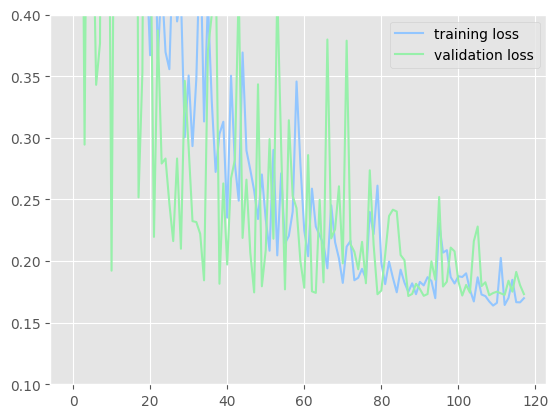

In [32]:
model = Sequential([
    Dense(76,activation='relu',name='hidden_layer1'),
    Dense(64,activation='relu',name='hidden_layer2'),
    Dense(1, activation='sigmoid', name='output')])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.002056138865204246),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.Accuracy()])

print('--------- TRAINING ---------')
history = model.fit(x = np.array(input_train), 
                    y = np.array(truth_train), 
                    validation_data=(np.array(input_valid), np.array(truth_valid)), 
                    epochs = 200,
                    batch_size=1024,
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=30, restore_best_weights=True)])  

plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.ylim(0.1, 0.4)
plt.legend();

#### Saving Output

In [35]:
predictions = model.predict(test[opt_features])[:, 0]

np.savetxt('outputs/Classification_RizNoronha_TensorFlowNN_VariableList.txt', opt_features, fmt='%s')
np.savetxt('outputs/Classification_RizNoronha_TensorFlowNN.txt', np.vstack((test.index, predictions)).T, delimiter=',', fmt=['%i', '%.18e'])

5021/5021 [==============================] - 20s 4ms/step


# Regression

In [27]:
X_e = train[train['Truth'] == 1][electron_variables]
y_e = train[train['Truth'] == 1]['p_truth_E']
X_e

actualInteractionsPerCrossing  averageInteractionsPerCrossing  \
0                           26.500000                       26.500000   
3                           37.500000                       37.500000   
4                           59.500000                       59.500000   
7                           35.500000                       35.500000   
11                          44.490002                       44.490002   
...                               ...                             ...   
162493                      35.500000                       35.500000   
162494                      34.490002                       34.490002   
162495                      59.500000                       59.500000   
162496                      11.490000                       11.490000   
162497                      44.490002                       44.490002   

        correctedActualMu  correctedAverageMu  correctedScaledActualMu  \
0               26.500000           26.500000                26.500000   
3               37.500000           37.500000                37.500000   
4               59.500000           59.500000                59.500000   
7               35.500000           35.500000                35.500000   
11              44.490002           44.490002                44.490002   
...                   ...                 ...                      ...   
162493          35.500000           35.500000                35.500000   
162494          34.490002           34.490002                34.490002   
162495          59.500000           59.500000                59.500000   
162496          11.490000           11.490000                11.490000   
162497          44.490002           44.490002                44.490002   

        correctedScaledAverageMu  NvtxReco  p_nTracks    p_pt_track     p_eta  \
0                      26.500000      18.0        3.0  42011.792969  1.834715   
3                      37.500000      17.0        2.0  44975.042969 -2.023659   
4                      59.500000      33.0        7.0  10956.218750  2.069837   
7                      35.500000      20.0        5.0  24223.316406  1.984269   
11                     44.490002      26.0        1.0  33938.906250  2.044807   
...                          ...       ...        ...           ...       ...   
162493                 35.500000      18.0        7.0  37901.839844  1.783071   
162494                 34.490002      21.0        3.0  20513.746094 -2.246926   
162495                 59.500000      34.0        2.0  39926.601562 -1.856813   
162496                 11.490000      10.0        4.0   5002.065430  1.953580   
162497                 44.490002      28.0        5.0  37733.097656 -1.644274   

        ...   p_E5x7_Lr0    p_E5x7_Lr1     p_E5x7_Lr2   p_E5x7_Lr3  \
0       ...   215.588013  43402.332031   74045.820312   337.980713   
3       ...     0.000000  27372.955078  104002.000000   921.178040   
4       ...     0.000000  45745.859375   87924.406250   -75.167221   
7       ...     0.000000  39245.539062   75593.671875  1672.360107   
11      ...     0.000000  32873.839844   81557.367188   184.990524   
...     ...          ...           ...            ...          ...   
162493  ...  9658.285156  49876.812500   85073.117188  2255.361328   
162494  ...     0.000000  70740.851562   83686.460938  -424.531433   
162495  ...  1064.037109  35473.875000   86889.070312   867.511475   
162496  ...     0.000000  36722.617188   79933.289062   352.093262   
162497  ...  7650.331543  26506.359375   52808.492188   287.444580   

        p_E7x11_Lr0   p_E7x11_Lr1    p_E7x11_Lr2  p_E7x11_Lr3   p_E7x7_Lr0  \
0        273.708801  43091.683594   74447.539062   470.177124   273.708801   
3          0.000000  27101.673828  106995.789062  1127.115356     0.000000   
4          0.000000  45947.109375   93710.968750  -188.182098     0.000000   
7          0.000000  39520.097656   77926.218750  2248.715820     0.000000   
11         0.000000  32153.529297   83

In [28]:
y_e.sort_values()

90459       2462.046143
133307      2506.251221
132518      2512.538574
17286       3020.244141
95044       3274.316895
              ...      
90457     314317.406250
99479     315013.843750
33907     323969.875000
55749     414221.937500
43861     478980.312500
Name: p_truth_E, Length: 121495, dtype: float64

## Verstack


 * Initiating LGBMTuner.fit
     . Settings:
     .. Trying 100 trials
     .. Evaluation metric: mae 
     .. Study direction: minimize mean_absolute_error

     . Trial number: 0 finished
     .. Optimization score (lower-better): mean_absolute_error: 6125.337711698444
     .. Evaluation score (lower-better): mae: 6125.337711698444
 ...........................................................................
     . Trial number: 1 finished
     .. Optimization score (lower-better): mean_absolute_error: 6001.38301073298
     .. Evaluation score (lower-better): mae: 6001.38301073298
 ...........................................................................
     . Trial number: 2 finished
     .. Optimization score (lower-better): mean_absolute_error: 6075.394999396071
     .. Evaluation score (lower-better): mae: 6075.394999396071
 ...........................................................................
     . Trial number: 3 finished
     .. Optimization score (lower-better): mea

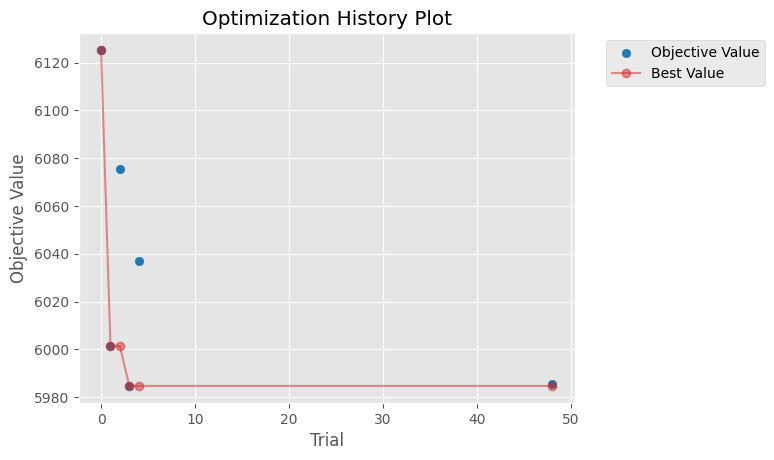

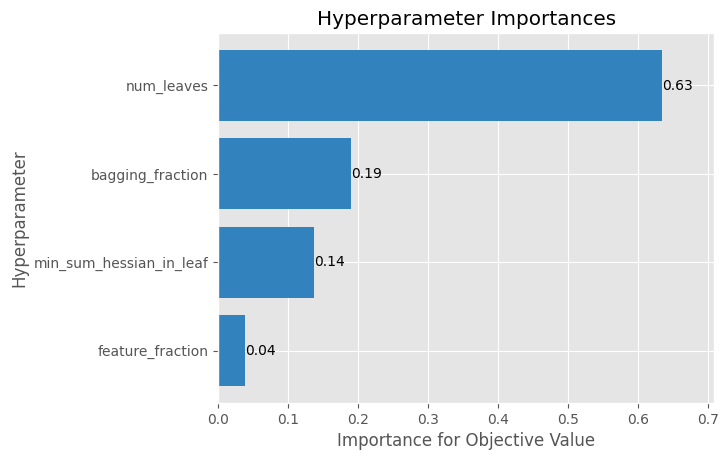

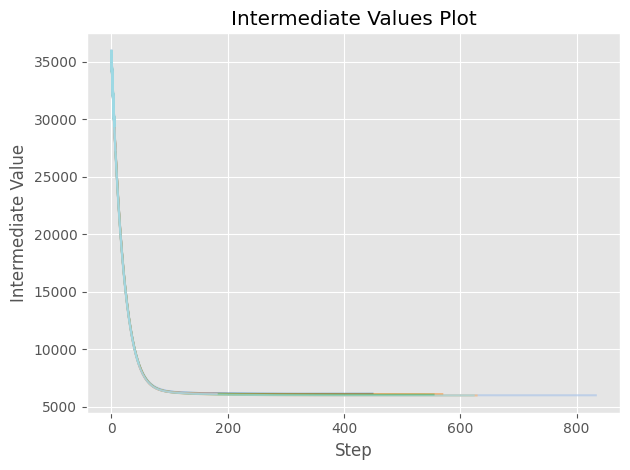

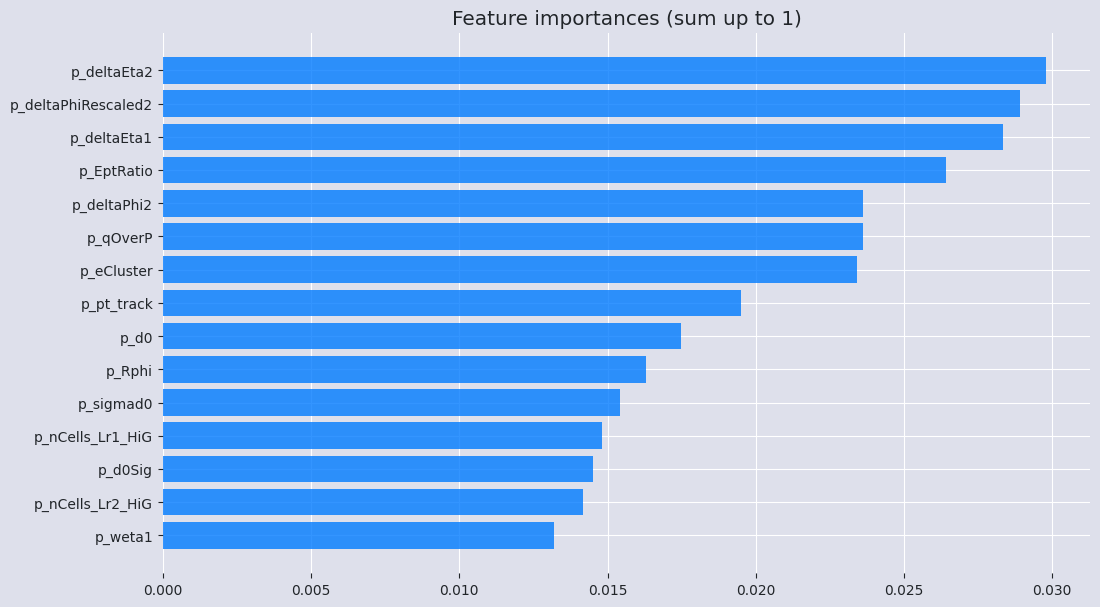


     . Optuna hyperparameters optimization finished
     .. Best trial number: 3    |     mean_absolute_error:            5984.671337647358
 ---------------------------------------------------------------------------
     . num_iterations optimization finished
     .. best iteration:  768   |     mae:           164910495.41929498

Time elapsed for fit execution: 2 min 19.449 sec


In [29]:
obj = verstack.LGBMTuner(metric='mae', visualization=True)
obj.fit(X_e, y_e)

In [30]:
opt_features = list(obj.feature_importances.sort_values(ascending=False)[:20].index)
obj.feature_importances.sort_values(ascending=False)[:20]

p_deltaEta2                       0.02979
p_deltaPhiRescaled2               0.02891
p_deltaEta1                       0.02835
p_EptRatio                        0.02642
p_deltaPhi2                       0.02362
p_qOverP                          0.02362
p_eCluster                        0.02340
p_pt_track                        0.01951
p_d0                              0.01749
p_Rphi                            0.01631
p_sigmad0                         0.01542
p_nCells_Lr1_HiG                  0.01482
p_d0Sig                           0.01452
p_nCells_Lr2_HiG                  0.01416
p_weta1                           0.01318
p_Reta                            0.01294
p_DeltaE                          0.01278
p_ptconecoreTrackPtrCorrection    0.01252
p_core57cellsEnergyCorrection     0.01238
p_weta2                           0.01236
dtype: float64


 * Initiating LGBMTuner.fit
     . Settings:
     .. Trying 200 trials
     .. Evaluation metric: mae 
     .. Study direction: minimize mean_absolute_error

     . Trial number: 0 finished
     .. Optimization score (lower-better): mean_absolute_error: 6463.081347569283
     .. Evaluation score (lower-better): mae: 6463.081347569283
 ...........................................................................
     . Trial number: 1 finished
     .. Optimization score (lower-better): mean_absolute_error: 6602.640038770107
     .. Evaluation score (lower-better): mae: 6602.640038770107
 ...........................................................................
     . Trial number: 2 finished
     .. Optimization score (lower-better): mean_absolute_error: 6289.512353271378
     .. Evaluation score (lower-better): mae: 6289.512353271378
 ...........................................................................
     . Trial number: 3 finished
     .. Optimization score (lower-better): m

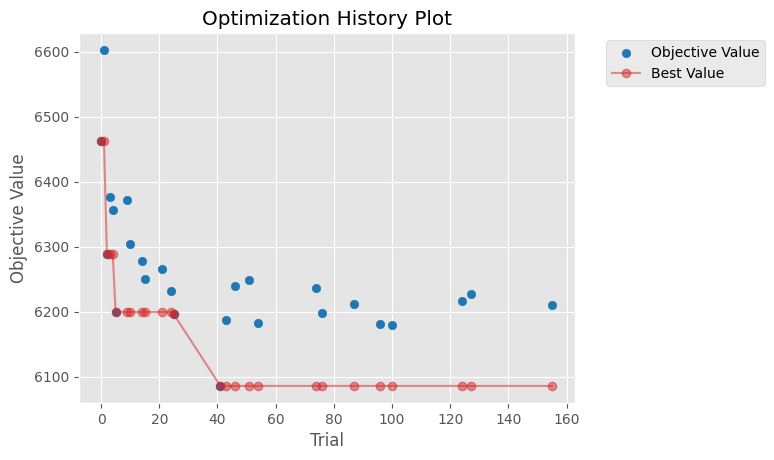

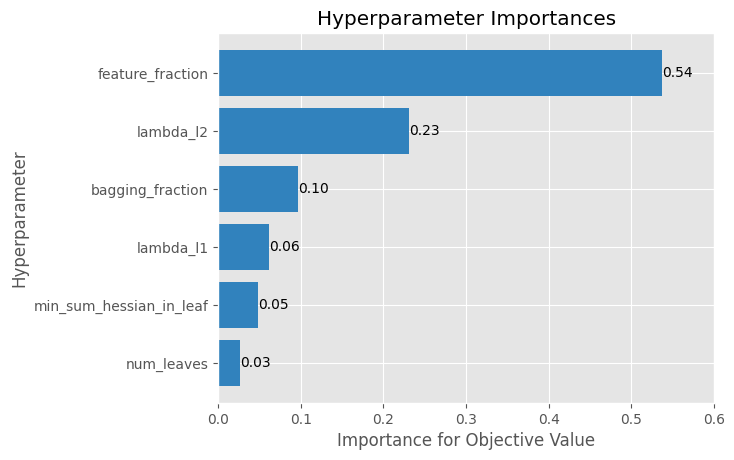

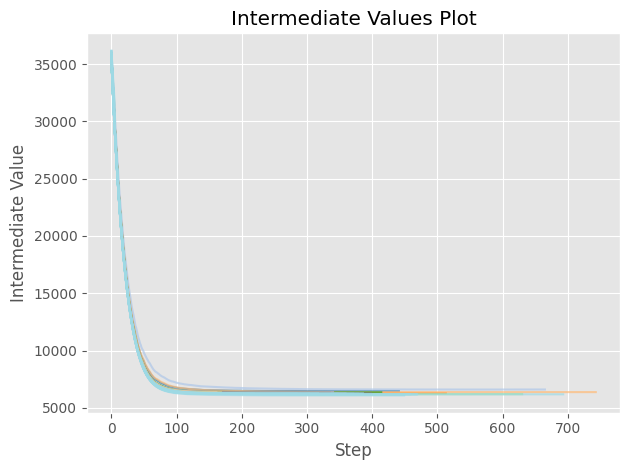

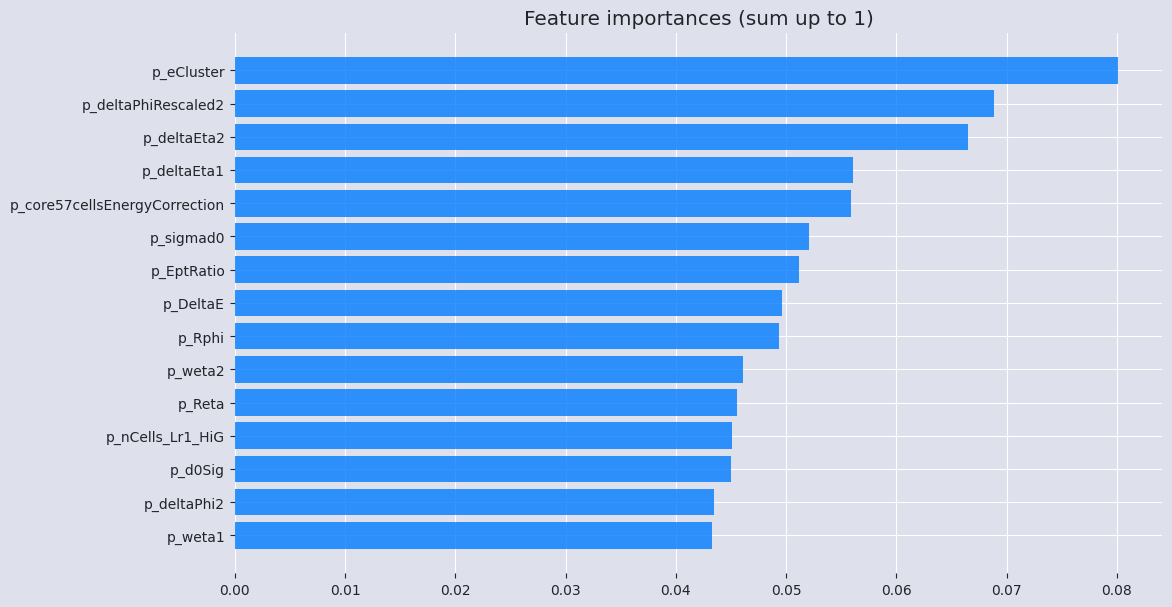


     . Optuna hyperparameters optimization finished
     .. Best trial number:41    |     mean_absolute_error:            6085.909984737588
 ---------------------------------------------------------------------------
     . num_iterations optimization finished
     .. best iteration:  571   |     mae:           167703085.12180153

Time elapsed for fit execution: 1 min 40.895 sec


In [31]:
obj = verstack.LGBMTuner(metric='mae', visualization=True, trials=200)
obj.fit(X_e[opt_features], y_e)

#### Saving Output

In [32]:
predictions = obj.predict(test[opt_features])

np.savetxt('outputs/Regression_RizNoronha_LightGBM_VariableList.txt', opt_features, fmt='%s')
np.savetxt('outputs/Regression_RizNoronha_LightGBM.txt', np.vstack((test.index, predictions)).T, delimiter=',', fmt=['%i', '%.18e'])

## Neural Network, Optuna

In [33]:
scalerX = PowerTransformer().fit(X_e)
scalerY = StandardScaler().fit(np.array(y_e).reshape(-1, 1))

X_e_transform = scalerX.transform(X_e)
y_e_transform = scalerY.transform(np.array(y_e).reshape(-1, 1))
# y_e_transform = y_e_transform[:, 0]

X_e_transform = pd.DataFrame(X_e_transform, columns=X_e.columns)

In [34]:
obj = verstack.LGBMTuner(metric='mae', visualization=False)
obj.fit(X_e_transform, pd.Series(y_e_transform[:, 0]))
opt_features = list(obj.feature_importances.sort_values(ascending=False)[:20].index)
obj.feature_importances.sort_values(ascending=False)[:20]


 * Initiating LGBMTuner.fit
     . Settings:
     .. Trying 100 trials
     .. Evaluation metric: mae 
     .. Study direction: minimize mean_absolute_error

     . Trial number: 0 finished
     .. Optimization score (lower-better): mean_absolute_error: 0.13580650372801836
     .. Evaluation score (lower-better): mae: 0.13580650372801836
 ...........................................................................
     . Trial number: 1 finished
     .. Optimization score (lower-better): mean_absolute_error: 0.13157482667730797
     .. Evaluation score (lower-better): mae: 0.13157482667730797
 ...........................................................................
     . Trial number: 2 finished
     .. Optimization score (lower-better): mean_absolute_error: 0.1339472581284322
     .. Evaluation score (lower-better): mae: 0.1339472581284322
 ...........................................................................
     . Trial number: 3 finished
     .. Optimization score (lower-

p_deltaEta1                       0.02628
p_deltaEta2                       0.02596
p_deltaPhiRescaled2               0.02520
p_EptRatio                        0.02508
p_deltaPhi2                       0.02433
p_qOverP                          0.02168
p_pt_track                        0.02150
p_eCluster                        0.01825
p_d0                              0.01754
p_Rphi                            0.01643
p_sigmad0                         0.01472
p_d0Sig                           0.01416
p_nCells_Lr1_HiG                  0.01376
p_deltaPhiFromLastMeasurement     0.01315
p_ptconecoreTrackPtrCorrection    0.01310
p_nCells_Lr2_HiG                  0.01262
p_deltaPhi1                       0.01245
p_Reta                            0.01223
p_weta2                           0.01222
p_weta1                           0.01190
dtype: float64

In [10]:
opt_features = ['p_deltaEta2'                   ,'p_deltaPhiRescaled2'           ,'p_EptRatio'                    ,'p_deltaEta1'                   ,'p_qOverP'                      ,'p_deltaPhi2'                   ,'p_eCluster'                    ,'p_pt_track'                    ,'p_Rphi'                        ,'p_d0'                          ,'p_sigmad0'                     ,'p_nCells_Lr1_HiG'              ,'p_nCells_Lr2_HiG'              ,'p_d0Sig'                       ,'p_Reta'                        ,'p_weta2'                       ,'p_weta1'                       ,'p_ptconecoreTrackPtrCorrection','p_DeltaE'                      ,'p_E_Lr2_HiG'  ]
opt_features

['p_deltaEta2',
 'p_deltaPhiRescaled2',
 'p_EptRatio',
 'p_deltaEta1',
 'p_qOverP',
 'p_deltaPhi2',
 'p_eCluster',
 'p_pt_track',
 'p_Rphi',
 'p_d0',
 'p_sigmad0',
 'p_nCells_Lr1_HiG',
 'p_nCells_Lr2_HiG',
 'p_d0Sig',
 'p_Reta',
 'p_weta2',
 'p_weta1',
 'p_ptconecoreTrackPtrCorrection',
 'p_DeltaE',
 'p_E_Lr2_HiG']

In [35]:
scalerX = PowerTransformer().fit(X_e[opt_features])
scalerY = StandardScaler().fit(np.array(y_e).reshape(-1, 1))

X_e_transform = scalerX.transform(X_e[opt_features])
y_e_transform = scalerY.transform(np.array(y_e).reshape(-1, 1))

X_e_transform = pd.DataFrame(X_e_transform, columns=opt_features)

input_train, input_valid, truth_train, truth_valid = train_test_split(X_e_transform, y_e_transform, train_size=0.8, random_state=42)

In [36]:
def objective(trial):
  n_layers = trial.suggest_int("n_layers", 1, 4)
  model = tf.keras.Sequential()
  # model.add(Dense(len(input_train.columns),activation='relu',name='input_layer'))  # I think keras automatically does this?
  for i in range(n_layers):
    num_hidden = trial.suggest_int("n_units_l{}".format(i), 1, 128, log=True)
    model.add(Dense(num_hidden, activation="relu"))
  model.add(Dense(1, activation='selu', name='output'))

  lr = trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True)
  model.compile(tf.optimizers.Adam(learning_rate=lr),
                tf.losses.MAE)
  history = model.fit(x = np.array(input_train), 
                      y = np.array(truth_train), 
                      validation_data=(np.array(input_valid), np.array(truth_valid)), 
                      epochs = 200,
                      batch_size=1024,
                      callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=30, restore_best_weights=True)],
                      verbose = 0)  
  return np.min(history.history['val_loss'])

In [37]:
# study = optuna.create_study(direction='minimize')
study = joblib.load('data/optuna_tf_regression.study')

# study.optimize(objective, n_trials=90, show_progress_bar=True)
# joblib.dump(study, 'data/optuna_tf_regression.study')

print('Number of finished trials: {}'.format(len(study.trials)))
print('Best trial:')
trial = study.best_trial

print('  Value: {}'.format(trial.value))
print('  Params: ')

for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

Number of finished trials: 100
Best trial:
  Value: 0.12704071402549744
  Params: 
    n_layers: 3
    n_units_l0: 67
    n_units_l1: 6
    n_units_l2: 36
    learning_rate: 0.0071684283351604716


In [38]:
study.trials_dataframe().sort_values('value')

number     value             datetime_start          datetime_complete  \
86      86  0.127041 2023-05-21 17:18:01.649548 2023-05-21 17:18:40.427704   
66      66  0.127725 2023-05-21 17:10:56.613576 2023-05-21 17:11:20.009506   
90      90  0.127758 2023-05-21 17:19:59.479038 2023-05-21 17:20:26.221119   
78      78  0.127897 2023-05-21 17:15:31.151412 2023-05-21 17:15:46.519199   
71      71  0.127901 2023-05-21 17:12:42.105567 2023-05-21 17:13:21.362585   
..     ...       ...                        ...                        ...   
58      58  0.144022 2023-05-21 17:07:35.581925 2023-05-21 17:08:10.477579   
10      10  0.145586 2023-05-21 16:48:56.907776 2023-05-21 16:49:22.228222   
7        7  0.185294 2023-05-21 16:47:14.787853 2023-05-21 16:47:34.702580   
1        1  0.802042 2023-05-21 16:45:54.840681 2023-05-21 16:46:00.730653   
12      12  0.802048 2023-05-21 16:50:01.745692 2023-05-21 16:50:09.957752   

                 duration  params_learning_rate  params_n_layers  \
86 0 days 00:00:38.778156              0.007168                3   
66 0 days 00:00:23.395930              0.002643                3   
90 0 days 00:00:26.742081              0.004958                3   
78 0 days 00:00:15.367787              0.005517                3   
71 0 days 00:00:39.257018              0.003102                3   
..                    ...                   ...              ...   
58 0 days 00:00:34.895654              0.000011                3   
10 0 days 00:00:25.320446              0.000018                1   
7  0 days 00:00:19.914727              0.000927                2   
1  0 days 00:00:05.889972              0.008286                3   
12 0 days 00:00:08.212060              0.000102                4   

    params_n_units_l0  params_n_units_l1  params_n_units_l2  \
86                 67                6.0               36.0   
66                125                9.0               11.0   
90                 64                5.0               34.0   
78                106                4.0               14.0   
71                111                8.0                9.0   
..                ...                ...                ...   
58                123               24.0                5.0   
10                124                NaN                NaN   
7                   2                3.0                NaN   
1                   1                1.0                8.0   
12                 64                9.0                1.0   

    params_n_units_l3     state  
86                NaN  COMPLETE  
66                NaN  COMPLETE  
90                NaN  COMPLETE  
78                NaN  COMPLETE  
71                NaN  COMPLETE  
..                ...       ...  
58                NaN  COMPLETE  
10                NaN  COMPLETE  
7                 NaN  COMPLETE  
1                 NaN  COMPLETE  
12                1.0  COMPLETE  

[100 rows x 12 columns]

In [39]:
# model = Sequential([
#     Dense(50,activation='relu',name='hidden_layer1'),
#     Dense(25,activation='relu',name='hidden_layer2'),
#     Dense(23,activation='relu',name='hidden_layer3'),
#     Dense(10,activation='relu',name='hidden_layer4'),
#     Dense(1, activation='selu', name='output')])

# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
#               loss=tf.keras.metrics.MAE,
#               metrics=[tf.keras.metrics.MSE])

model = Sequential([
    Dense(67,activation='relu',name='hidden_layer1'),
    Dense(6,activation='relu',name='hidden_layer2'),
    Dense(36,activation='relu',name='hidden_layer3'),
    Dense(1, activation='selu', name='output')])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0071684283351604716),
              loss=tf.keras.metrics.MAE,
              metrics=[tf.keras.metrics.MSE])


print('--------- TRAINING ---------')
history = model.fit(x = np.array(input_train), 
                    y = np.array(truth_train), 
                    validation_data=(np.array(input_valid), np.array(truth_valid)), 
                    epochs = 200,
                    batch_size=1024,
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=30, restore_best_weights=True)])  


--------- TRAINING ---------
Epoch 1/200
95/95 [==============================] - 1s 3ms/step - loss: 0.2128 - mean_squared_error: 0.1572 - val_loss: 0.1440 - val_mean_squared_error: 0.0985
Epoch 2/200
95/95 [==============================] - 0s 2ms/step - loss: 0.1425 - mean_squared_error: 0.0938 - val_loss: 0.1389 - val_mean_squared_error: 0.0921
Epoch 3/200
95/95 [==============================] - 0s 2ms/step - loss: 0.1388 - mean_squared_error: 0.0918 - val_loss: 0.1403 - val_mean_squared_error: 0.0925
Epoch 4/200
95/95 [==============================] - 0s 2ms/step - loss: 0.1376 - mean_squared_error: 0.0910 - val_loss: 0.1377 - val_mean_squared_error: 0.0926
Epoch 5/200
95/95 [==============================] - 0s 2ms/step - loss: 0.1366 - mean_squared_error: 0.0907 - val_loss: 0.1385 - val_mean_squared_error: 0.0952
Epoch 6/200
95/95 [==============================] - 0s 2ms/step - loss: 0.1354 - mean_squared_error: 0.0905 - val_loss: 0.1356 - val_mean_squared_error: 0.0907
Epoch

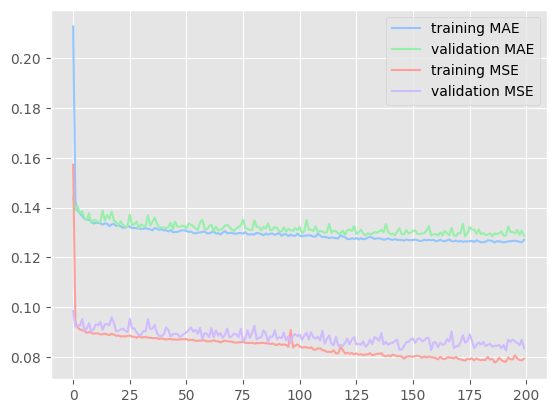

In [40]:
plt.plot(history.history['loss'], label='training MAE')
plt.plot(history.history['val_loss'], label='validation MAE')
plt.plot(history.history['mean_squared_error'], label='training MSE')
plt.plot(history.history['val_mean_squared_error'], label='validation MSE')
plt.legend();

#### Saving Output

760/760 [==============================] - 0s 537us/step


(array([1478., 4452., 5288., 4208., 3303., 2492., 1654.,  934.,  417.,
          73.]),
 array([-1.75809932, -1.25376201, -0.7494247 , -0.24508739,  0.25924993,
         0.76358724,  1.26792455,  1.77226186,  2.27659917,  2.78093648,
         3.28527379]),
 <BarContainer object of 10 artists>)

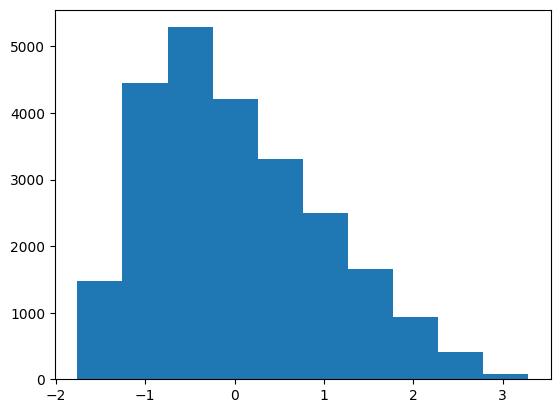

In [21]:
plt.hist(model.predict(input_valid))

In [41]:
scalerX_test = PowerTransformer().fit(test[opt_features])
test_transformed = scalerX_test.transform(test[opt_features])
predictions = model.predict(test_transformed)
predictions = scalerY.inverse_transform(predictions)
predictions = predictions[:, 0]

np.savetxt('outputs/Regression_RizNoronha_TensorFlowScaledNN_VariableList.txt', opt_features, fmt='%s')
np.savetxt('outputs/Regression_RizNoronha_TensorFlowScaledNN.txt', np.vstack((test.index, predictions)).T, delimiter=',', fmt=['%i', '%.15e'])

5021/5021 [==============================] - 2s 481us/step


In [46]:
input_train_1, input_valid_1, truth_train_1, truth_valid_1 = train_test_split(X_e[opt_features], y_e, train_size=0.8, random_state=42)

predictions = model.predict(input_valid)
predictions = scalerY.inverse_transform(predictions)
predictions = predictions[:, 0]

tf.losses.mean_absolute_error(truth_valid_1, predictions).numpy()

760/760 [==============================] - 0s 516us/step


5851.974

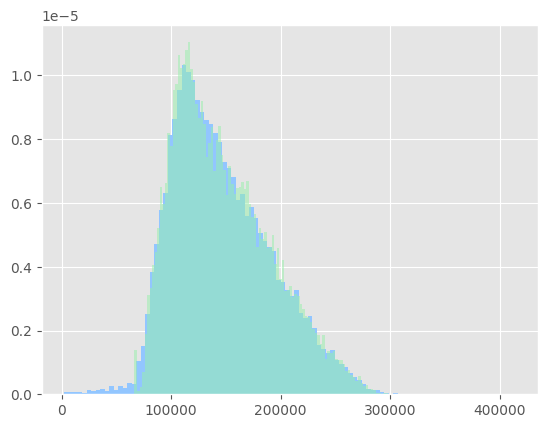

In [45]:
plt.hist(truth_valid_1, bins=100, density=True)
plt.hist(predictions, alpha=0.5, bins=100, density=True);

# Dimensionality Reduction

## UMAP

### Untransformed data

UMAP( verbose=True)
Wed May 17 16:46:17 2023 Construct fuzzy simplicial set
Wed May 17 16:46:18 2023 Finding Nearest Neighbors
Wed May 17 16:46:18 2023 Building RP forest with 25 trees
Wed May 17 16:46:23 2023 NN descent for 17 iterations
	 1  /  17
	 2  /  17
	 3  /  17
	Stopping threshold met -- exiting after 3 iterations
Wed May 17 16:46:42 2023 Finished Nearest Neighbor Search
Wed May 17 16:46:46 2023 Construct embedding


Epochs completed: 100%| ██████████ 200/200 [00:22]


Wed May 17 16:47:25 2023 Finished embedding


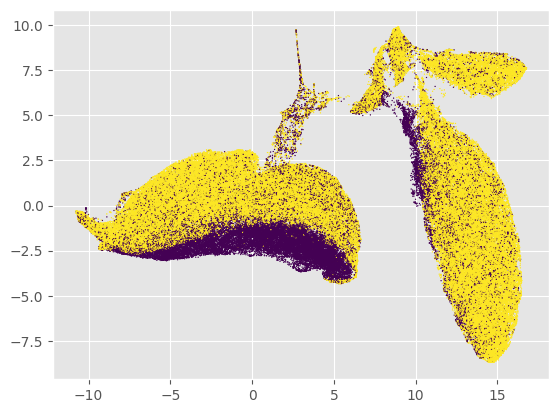

In [ ]:
import umap
import matplotlib.pyplot as plt

# running UMAP
# use the non-standardized data X[:, flux_idxs]
map_obj = umap.UMAP(verbose=True)
y_umap = map_obj.fit_transform(X)

plt.scatter(y_umap[:,0], y_umap[:, 1], c=y.values, s=0.2)

### Transformed data with `StandardScaler`

UMAP( verbose=True)
Wed May 17 11:28:29 2023 Construct fuzzy simplicial set
Wed May 17 11:28:29 2023 Finding Nearest Neighbors
Wed May 17 11:28:29 2023 Building RP forest with 25 trees
Wed May 17 11:28:31 2023 NN descent for 17 iterations
	 1  /  17
	 2  /  17
	 3  /  17
	 4  /  17
	Stopping threshold met -- exiting after 4 iterations
Wed May 17 11:28:34 2023 Finished Nearest Neighbor Search
Wed May 17 11:28:35 2023 Construct embedding


Epochs completed: 100%| ██████████ 200/200 [00:24]


Wed May 17 11:29:16 2023 Finished embedding


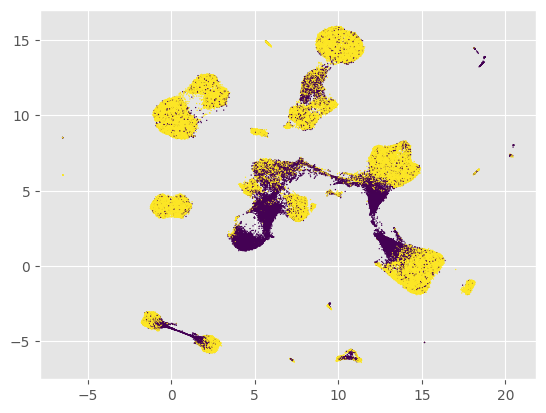

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_transform = scaler.fit_transform(X, y)

X_transform = pd.DataFrame(X_transform, columns=X.columns)

map_obj = umap.UMAP(verbose=True)
y_umap = map_obj.fit_transform(X_transform)

plt.scatter(y_umap[:,0], y_umap[:, 1], c=y.values, s=0.2)

### Transformed data with `RobustScaler`

UMAP( verbose=True)
Wed May 17 16:47:29 2023 Construct fuzzy simplicial set
Wed May 17 16:47:29 2023 Finding Nearest Neighbors
Wed May 17 16:47:29 2023 Building RP forest with 25 trees
Wed May 17 16:47:30 2023 NN descent for 17 iterations
	 1  /  17
	 2  /  17
	 3  /  17
	 4  /  17
	Stopping threshold met -- exiting after 4 iterations
Wed May 17 16:47:33 2023 Finished Nearest Neighbor Search
Wed May 17 16:47:34 2023 Construct embedding


Epochs completed: 100%| ██████████ 200/200 [00:24]


Wed May 17 16:48:13 2023 Finished embedding


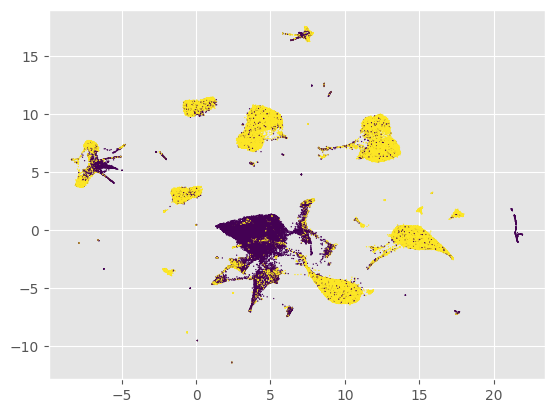

In [ ]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler(quantile_range=[10, 90])

X_transform = scaler.fit_transform(X, y)

X_transform = pd.DataFrame(X_transform, columns=X.columns)

map_obj = umap.UMAP(verbose=True)
y_umap = map_obj.fit_transform(X_transform)

plt.scatter(y_umap[:,0], y_umap[:, 1], c=y.values, s=0.2)

### Transformed data with `QuantileTransformer`

UMAP( verbose=True)
Wed May 17 11:23:52 2023 Construct fuzzy simplicial set
Wed May 17 11:23:53 2023 Finding Nearest Neighbors
Wed May 17 11:23:53 2023 Building RP forest with 25 trees
Wed May 17 11:23:54 2023 NN descent for 17 iterations
	 1  /  17
	 2  /  17
	 3  /  17
	 4  /  17
	 5  /  17
	Stopping threshold met -- exiting after 5 iterations
Wed May 17 11:23:58 2023 Finished Nearest Neighbor Search
Wed May 17 11:23:58 2023 Construct embedding


Epochs completed: 100%| ██████████ 200/200 [00:25]


Wed May 17 11:24:41 2023 Finished embedding


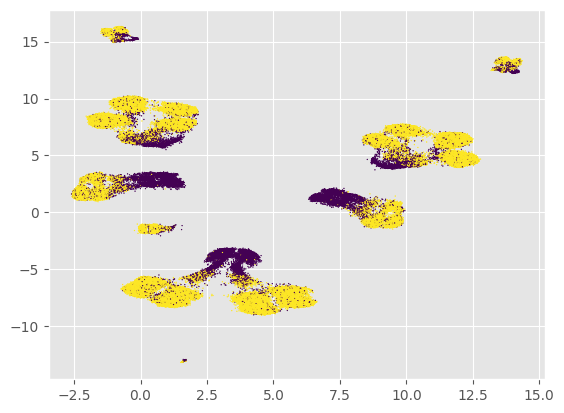

In [ ]:
from sklearn.preprocessing import QuantileTransformer

scaler = QuantileTransformer()

X_transform = scaler.fit_transform(X, y)

X_transform = pd.DataFrame(X_transform, columns=X.columns)

map_obj = umap.UMAP(verbose=True)
y_umap = map_obj.fit_transform(X_transform)

plt.scatter(y_umap[:,0], y_umap[:, 1], c=y.values, s=0.2)

### Transformed data with `PowerTransformer`

UMAP( verbose=True)
Wed May 17 11:26:44 2023 Construct fuzzy simplicial set
Wed May 17 11:26:44 2023 Finding Nearest Neighbors
Wed May 17 11:26:44 2023 Building RP forest with 25 trees
Wed May 17 11:26:46 2023 NN descent for 17 iterations
	 1  /  17
	 2  /  17
	 3  /  17
	 4  /  17
	 5  /  17
	Stopping threshold met -- exiting after 5 iterations
Wed May 17 11:26:49 2023 Finished Nearest Neighbor Search
Wed May 17 11:26:50 2023 Construct embedding


Epochs completed: 100%| ██████████ 200/200 [00:25]


Wed May 17 11:27:33 2023 Finished embedding


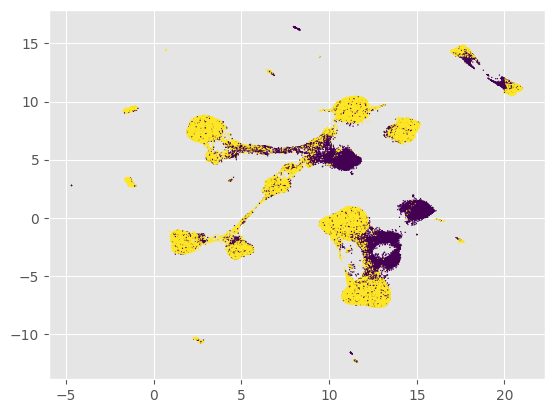

In [ ]:
from sklearn.preprocessing import PowerTransformer

scaler = PowerTransformer()

X_transform = scaler.fit_transform(X, y)

X_transform = pd.DataFrame(X_transform, columns=X.columns)

map_obj = umap.UMAP(verbose=True)
y_umap = map_obj.fit_transform(X_transform)

plt.scatter(y_umap[:,0], y_umap[:, 1], c=y.values, s=0.2)

## t-SNE

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 162500 samples in 0.092s...
[t-SNE] Computed neighbors for 162500 samples in 33.532s...
[t-SNE] Computed conditional probabilities for sample 1000 / 162500
[t-SNE] Computed conditional probabilities for sample 2000 / 162500
[t-SNE] Computed conditional probabilities for sample 3000 / 162500
[t-SNE] Computed conditional probabilities for sample 4000 / 162500
[t-SNE] Computed conditional probabilities for sample 5000 / 162500
[t-SNE] Computed conditional probabilities for sample 6000 / 162500
[t-SNE] Computed conditional probabilities for sample 7000 / 162500
[t-SNE] Computed conditional probabilities for sample 8000 / 162500
[t-SNE] Computed conditional probabilities for sample 9000 / 162500
[t-SNE] Computed conditional probabilities for sample 10000 / 162500
[t-SNE] Computed conditional probabilities for sample 11000 / 162500
[t-SNE] Computed conditional probabilities for sample 12000 / 162500
[t-SNE] Computed conditional probab

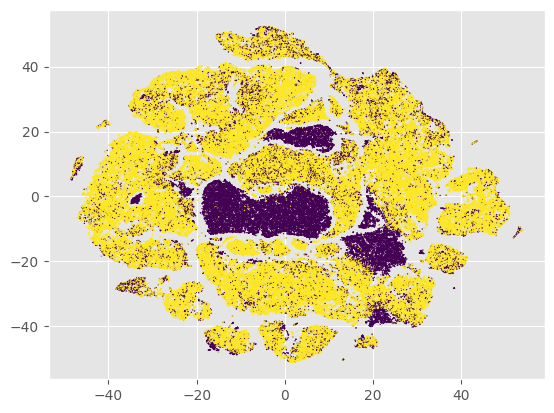

In [ ]:
from sklearn.manifold import TSNE

# running t-SNE
# use the non-standardized data X[:, flux_idxs]
tsne = TSNE(verbose=2)
y_tsne = tsne.fit_transform(X)

plt.scatter(y_tsne[:,0], y_tsne[:, 1], c=y.values, s=0.2)


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 162500 samples in 0.101s...
[t-SNE] Computed neighbors for 162500 samples in 33.655s...
[t-SNE] Computed conditional probabilities for sample 1000 / 162500
[t-SNE] Computed conditional probabilities for sample 2000 / 162500
[t-SNE] Computed conditional probabilities for sample 3000 / 162500
[t-SNE] Computed conditional probabilities for sample 4000 / 162500
[t-SNE] Computed conditional probabilities for sample 5000 / 162500
[t-SNE] Computed conditional probabilities for sample 6000 / 162500
[t-SNE] Computed conditional probabilities for sample 7000 / 162500
[t-SNE] Computed conditional probabilities for sample 8000 / 162500
[t-SNE] Computed conditional probabilities for sample 9000 / 162500
[t-SNE] Computed conditional probabilities for sample 10000 / 162500
[t-SNE] Computed conditional probabilities for sample 11000 / 162500
[t-SNE] Computed conditional probabilities for sample 12000 / 162500
[t-SNE] Computed conditional probab

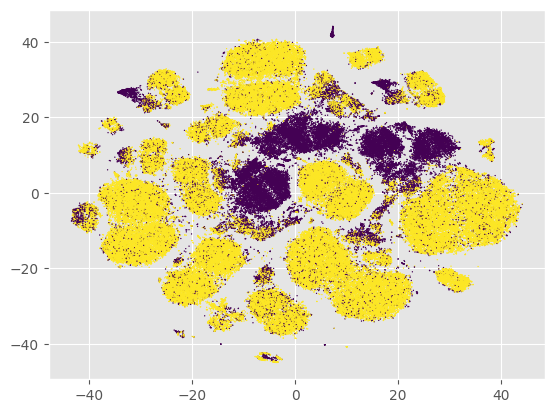

In [ ]:
from sklearn.manifold import TSNE


scaler = PowerTransformer()

X_transform = scaler.fit_transform(X, y)

X_transform = pd.DataFrame(X_transform, columns=X.columns)

# running t-SNE
# use the non-standardized data X[:, flux_idxs]
tsne = TSNE(verbose=1)
y_tsne = tsne.fit_transform(X_transform)

plt.scatter(y_tsne[:,0], y_tsne[:, 1], c=y.values, s=0.2)


# Clustering

## k-means

UMAP(n_epochs=500, verbose=True)
Sun May 21 21:17:11 2023 Construct fuzzy simplicial set
Sun May 21 21:17:11 2023 Finding Nearest Neighbors
Sun May 21 21:17:11 2023 Building RP forest with 25 trees
Sun May 21 21:17:16 2023 NN descent for 17 iterations
	 1  /  17
	 2  /  17
	Stopping threshold met -- exiting after 2 iterations
Sun May 21 21:17:36 2023 Finished Nearest Neighbor Search
Sun May 21 21:17:39 2023 Construct embedding


Epochs completed: 100%| ██████████ 500/500 [01:22]


Sun May 21 21:19:17 2023 Finished embedding


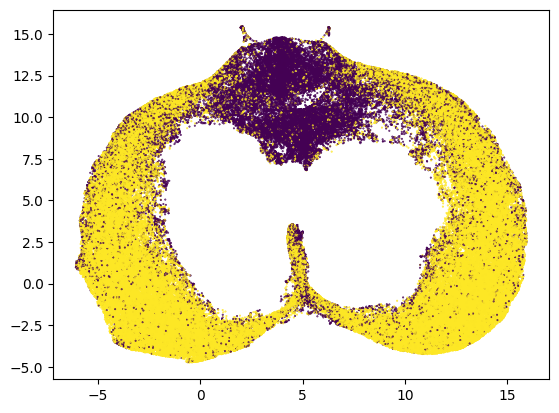

In [4]:
opt_features = ['p_deltaEta2', 'p_deltaPhiRescaled2', 'p_EptRatio', 'p_deltaEta1', 'p_qOverP']

X_transform = PowerTransformer().fit_transform(X[opt_features])

map_obj = umap.UMAP(verbose=True, n_epochs=500)
y_umap = map_obj.fit_transform(X_transform)
plt.scatter(y_umap[:, 0], y_umap[:, 1], c=y, s=0.2)

In [9]:
np.unique(dbscan.labels_, return_counts=True)

(array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
        16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,
        33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43], dtype=int64),
 array([   449, 161031,    122,     42,    114,     45,     16,     77,
            13,      9,    105,      8,     28,    103,     22,     34,
             5,     13,     18,      8,     10,     10,     25,      6,
             7,     23,     18,     18,     14,      5,      4,     12,
             7,      8,      7,      7,      9,      5,      5,      7,
             8,      5,      5,      8,      5], dtype=int64))

45

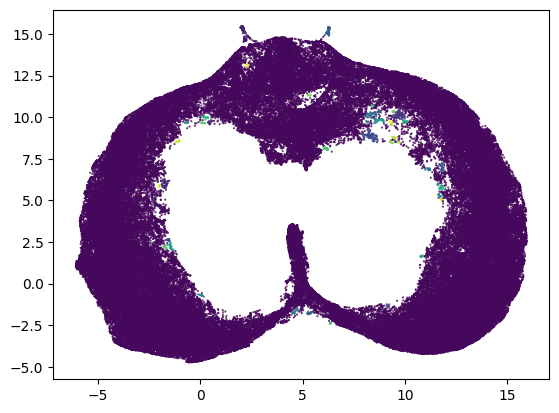

In [8]:
# n_clusters = 15

# kmeans = KMeans(n_clusters, random_state=42).fit(X_transform)
# plt.scatter(y_umap[:, 0], y_umap[:, 1], c=kmeans.labels_, s=0.2)
# plt.show()

dbscan = DBSCAN(0.1).fit(y_umap)
plt.scatter(y_umap[:, 0], y_umap[:, 1], c=dbscan.labels_, s=0.2)
len(np.unique(dbscan.labels_))

UMAP(n_epochs=500, verbose=True)
Sun May 21 21:25:28 2023 Construct fuzzy simplicial set
Sun May 21 21:25:28 2023 Finding Nearest Neighbors
Sun May 21 21:25:28 2023 Building RP forest with 25 trees
Sun May 21 21:25:28 2023 NN descent for 17 iterations
	 1  /  17
	 2  /  17
	Stopping threshold met -- exiting after 2 iterations
Sun May 21 21:25:30 2023 Finished Nearest Neighbor Search
Sun May 21 21:25:31 2023 Construct embedding


Epochs completed: 100%| ██████████ 500/500 [01:19]


Sun May 21 21:27:06 2023 Finished embedding
43


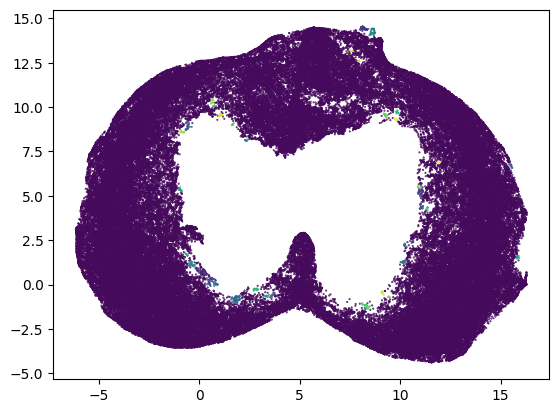

In [11]:
opt_features = ['p_deltaEta2', 'p_deltaPhiRescaled2', 'p_EptRatio', 'p_deltaEta1', 'p_qOverP']

X_transform = PowerTransformer().fit_transform(test[opt_features])

map_obj = umap.UMAP(verbose=True, n_epochs=500)
y_umap = map_obj.fit_transform(X_transform)

n_clusters = 15

dbscan = DBSCAN(0.1).fit(y_umap)
print(len(np.unique(dbscan.labels_)))
plt.scatter(y_umap[:, 0], y_umap[:, 1], c=dbscan.labels_, s=0.2)
plt.show()

np.savetxt('outputs/Clustering_RizNoronha_DBSCAN-BadPerformance_VariableList.txt', opt_features, fmt='%s')
np.savetxt('outputs/Clustering_RizNoronha_DBSCAN-BadPerformance.txt', np.vstack((test.index, dbscan.labels_)).T, delimiter=',', fmt=['%i', '%i'])

UMAP(n_epochs=500, verbose=True)
Sun May 21 21:27:57 2023 Construct fuzzy simplicial set
Sun May 21 21:27:57 2023 Finding Nearest Neighbors
Sun May 21 21:27:57 2023 Building RP forest with 25 trees
Sun May 21 21:27:58 2023 NN descent for 17 iterations
	 1  /  17
	 2  /  17
	Stopping threshold met -- exiting after 2 iterations
Sun May 21 21:28:00 2023 Finished Nearest Neighbor Search
Sun May 21 21:28:01 2023 Construct embedding


Epochs completed: 100%| ██████████ 500/500 [00:54]

Sun May 21 21:29:12 2023 Finished embedding


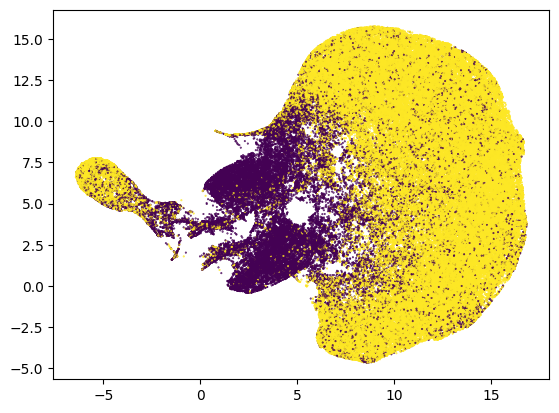

In [13]:
opt_features = ['p_deltaPhiRescaled2', 'p_ptconecoreTrackPtrCorrection', 'p_d0', 'p_d0Sig', 'p_deltaEta1']

X_transform = PowerTransformer().fit_transform(X[opt_features])

map_obj = umap.UMAP(verbose=True, n_epochs=500)
y_umap = map_obj.fit_transform(X_transform)
plt.scatter(y_umap[:, 0], y_umap[:, 1], c=y, s=0.2)

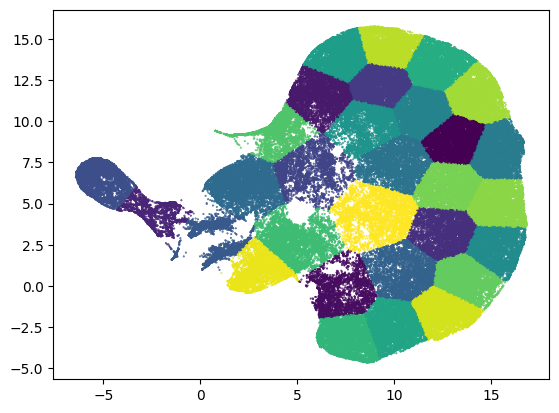

In [14]:
kmeans = KMeans(30, random_state=42).fit(y_umap)
plt.scatter(y_umap[:, 0], y_umap[:, 1], c=kmeans.labels_, s=0.2)
plt.show()

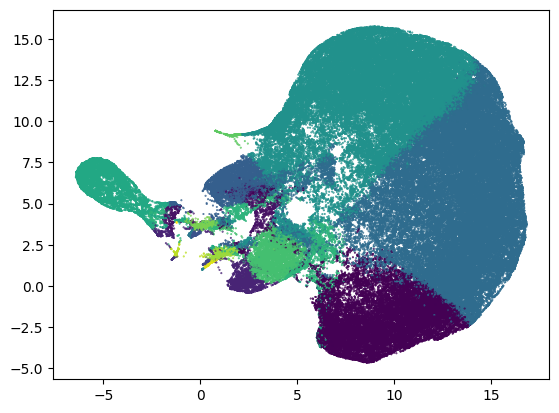

In [15]:
kmeans = KMeans(21, random_state=42).fit(X_transform)
plt.scatter(y_umap[:, 0], y_umap[:, 1], c=kmeans.labels_, s=0.2)
plt.show()

UMAP(n_epochs=500, verbose=True)
Sun May 21 21:29:24 2023 Construct fuzzy simplicial set
Sun May 21 21:29:24 2023 Finding Nearest Neighbors
Sun May 21 21:29:24 2023 Building RP forest with 25 trees
Sun May 21 21:29:25 2023 NN descent for 17 iterations
	 1  /  17
	 2  /  17
	Stopping threshold met -- exiting after 2 iterations
Sun May 21 21:29:27 2023 Finished Nearest Neighbor Search
Sun May 21 21:29:27 2023 Construct embedding


Epochs completed: 100%| ██████████ 500/500 [00:52]


Sun May 21 21:30:36 2023 Finished embedding


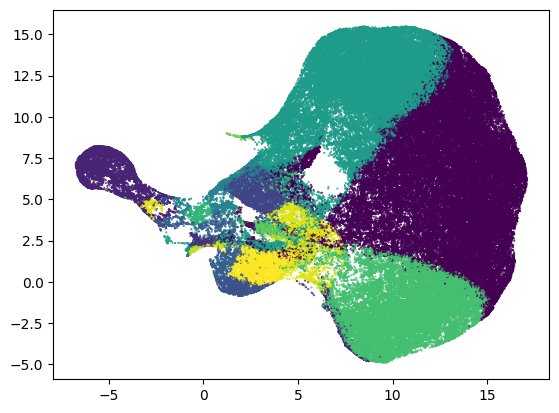

In [16]:
opt_features = ['p_deltaPhiRescaled2', 'p_ptconecoreTrackPtrCorrection', 'p_d0', 'p_d0Sig', 'p_deltaEta1']

X_transform = PowerTransformer().fit_transform(test[opt_features])

map_obj = umap.UMAP(verbose=True, n_epochs=500)
y_umap = map_obj.fit_transform(X_transform)

n_clusters = 21

kmeans = KMeans(n_clusters, random_state=42).fit(X_transform)
plt.scatter(y_umap[:, 0], y_umap[:, 1], c=kmeans.labels_, s=0.2)
plt.show()

np.savetxt('outputs/Clustering_RizNoronha_KNN2_VariableList.txt', opt_features, fmt='%s')
np.savetxt('outputs/Clustering_RizNoronha_KNN2.txt', np.vstack((test.index, kmeans.labels_)).T, delimiter=',', fmt=['%i', '%i'])

UMAP(n_epochs=500, verbose=True)
Sun May 21 21:30:41 2023 Construct fuzzy simplicial set
Sun May 21 21:30:41 2023 Finding Nearest Neighbors
Sun May 21 21:30:41 2023 Building RP forest with 25 trees
Sun May 21 21:30:42 2023 NN descent for 17 iterations
	 1  /  17
	 2  /  17
	Stopping threshold met -- exiting after 2 iterations
Sun May 21 21:30:44 2023 Finished Nearest Neighbor Search
Sun May 21 21:30:44 2023 Construct embedding


Epochs completed: 100%| ██████████ 500/500 [00:53]

Sun May 21 21:31:55 2023 Finished embedding


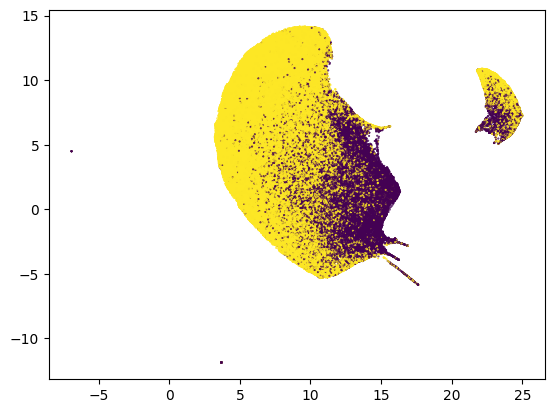

In [17]:
opt_features = ['p_deltaPhiRescaled2', 'p_ptconecoreTrackPtrCorrection', 'p_Rphi', 'p_sigmad0', 'p_d0Sig']

X_transform = PowerTransformer().fit_transform(X[opt_features])

map_obj = umap.UMAP(verbose=True, n_epochs=500)
y_umap = map_obj.fit_transform(X_transform)
plt.scatter(y_umap[:, 0], y_umap[:, 1], c=y, s=0.2)

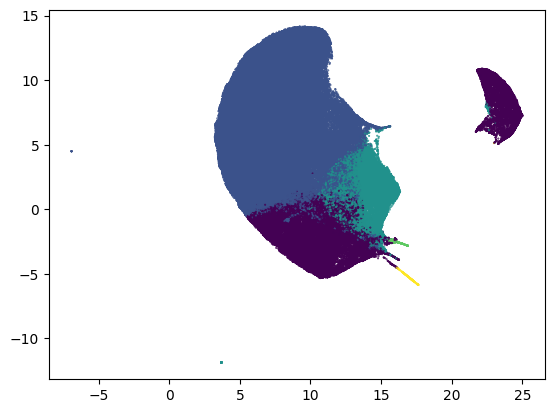

In [22]:
kmeans = KMeans(5, random_state=42).fit(X_transform)
plt.scatter(y_umap[:, 0], y_umap[:, 1], c=kmeans.labels_, s=0.2)

UMAP(n_epochs=500, verbose=True)
Sun May 21 21:34:07 2023 Construct fuzzy simplicial set
Sun May 21 21:34:07 2023 Finding Nearest Neighbors
Sun May 21 21:34:07 2023 Building RP forest with 25 trees
Sun May 21 21:34:07 2023 NN descent for 17 iterations
	 1  /  17
	 2  /  17
	Stopping threshold met -- exiting after 2 iterations
Sun May 21 21:34:09 2023 Finished Nearest Neighbor Search
Sun May 21 21:34:10 2023 Construct embedding


Epochs completed: 100%| ██████████ 500/500 [01:25]


Sun May 21 21:35:51 2023 Finished embedding


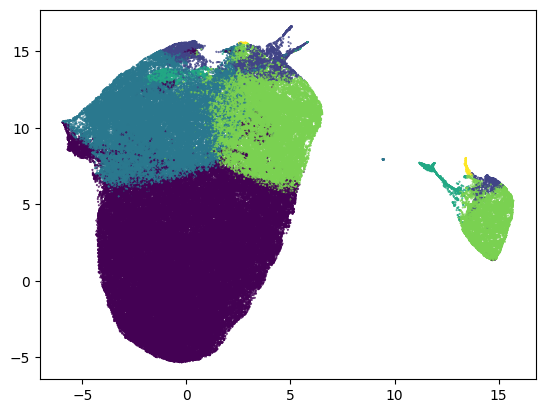

In [23]:
opt_features = ['p_deltaPhiRescaled2', 'p_ptconecoreTrackPtrCorrection', 'p_Rphi', 'p_sigmad0', 'p_d0Sig']

X_transform = PowerTransformer().fit_transform(test[opt_features])

map_obj = umap.UMAP(verbose=True, n_epochs=500)
y_umap = map_obj.fit_transform(X_transform)

n_clusters = 6

kmeans = KMeans(n_clusters, random_state=42).fit(X_transform)
plt.scatter(y_umap[:, 0], y_umap[:, 1], c=kmeans.labels_, s=0.2)

np.savetxt('outputs/Clustering_RizNoronha_KNN_VariableList.txt', opt_features, fmt='%s')
np.savetxt('outputs/Clustering_RizNoronha_KNN.txt', np.vstack((test.index, kmeans.labels_)).T, delimiter=',', fmt=['%i', '%i'])

## Other stuff (trials)

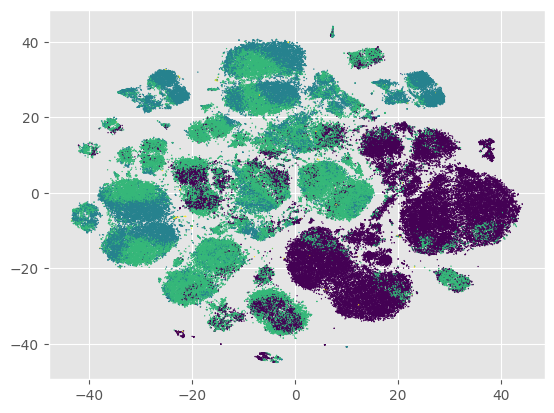

In [ ]:
from sklearn.cluster import KMeans

n_clusters = 10
kmeans = KMeans(n_clusters, random_state=42).fit(X)

plt.scatter(y_tsne[:,0], y_tsne[:, 1], c=kmeans.labels_ , s=0.2)

## DBSCAN

#### Clustering after dimensionality reduction

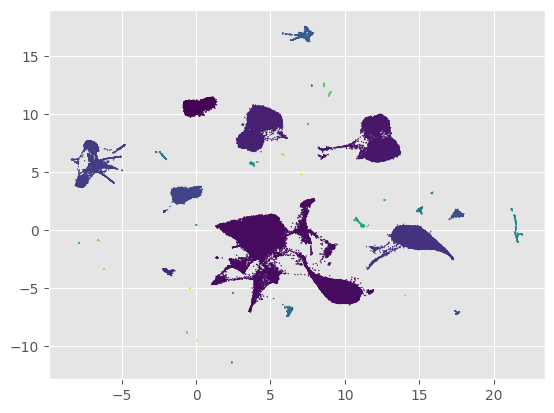

In [ ]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(0.5).fit(y_umap)

plt.scatter(y_umap[:,0], y_umap[:, 1], c=dbscan.labels_, s=0.2)